## Group Contributions
Everyone in the group did equal amounts of work. We met up throughout the quarter to work on this project.

# Abstract
The goal of this project is to explore what data can tell us about poetry. Poetry is something so abstract, but we wanted to see if we could create meaningful features from poetry and make observations using Python. Moving toward this goal, we utilized web scraping to create a large database of poems. We analyzed the structure of the dataset we obtained, including dates, author diversity, and languages of the poems. We then took a look at the substance of the poems, such as rhyme, emotion, and subject. We trained a logistic regression model to identify emotions in poetry. Using word frequency and tokenization, we turned poems into word vectors for emotion and subject prediction analysis. To apply what we learned, we created a feature that returns a poem with similar emotions to what a person is feeling. Using word trees representing poem subjects and emotions, we were able to view trends in poetry over time and by author. By getting poems from the internet into Python, we managed to derive a lot of meaning from the data. We turned something as abstract as poetry into something much more concrete—data.

# Introduction
This report explores how Python can be used to learn about poetry analytically, specifically focusing on subject, emotion, and rhyming. To delve into poetry using Python, we first had to assemble a dataset of poetry. We accomplished this by scraping the website poets.org, resulting in a data frame of roughly 13 thousand poems. Subsequently, we created visualizations of the data to gain insights into the poetry within our dataset. Continuing our analysis, we quantified rhyming in the poetry and developed interactive visualizations to analyze different metrics of rhyming, such as rhymes per word, and rhymes between lines. To examine the content of the poems themselves, we explored how sentiment analysis could be applied to poetry. Initially, we tokenized and calculated the frequency of words in a poem to create word vectors. Utilizing this data, we generated word clouds representing the most common words and emotions in a given author's poetry and within a specific time period. Subsequently, we extended our sentiment analysis to build a feature that, when given a prompt, determines the emotions of the prompt and returns poems with similar emotions.

# Research Question:
How can Python be used to turn poetry into useful data that can help us understand or predict it? Can we create data features for poetry? Can we quantify poetic elements such as structure and rhyme? Can we identify the emotions and subjects of a poem? Can we predict which poem matches the user's thoughts? What trends exist in subject and emotion among authors? What trends exist in subject and emotion over time periods?

# Scraping
We begin with attaining the dataset. For our poem analysis, we scraped poets.org, which had data on poetry formated fairly well. We designed a general scraping approach, as well as many support functions to utilize the readability that comes with Python. Short is better. Clear is beautiful.

We specifically scraped title, year, author, and the poem itself, with all the tabs and line breaks that were needed. This is not to say that some of the poems were missing a year or had the inccorrect year, and this is not to say that all poetry was is nice usable text formats.

In [ ]:
!pip install pronouncing
!pip install plotnine
!pip install plotly
!pip install ipywidgets
!pip install pyaudio
!pip install SpeechRecognition
!pip install textblob
!pip install wordcloud
!pip install networkx

import zipfile
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import pronouncing
import nltk.corpus
from nltk import pos_tag
from nltk.tokenize import word_tokenize
import plotnine
import matplotlib.pyplot as plt
from plotnine import ggplot, aes, geom_bar, ggtitle, xlab, ylab, scale_x_continuous, geom_point, geom_smooth
import concurrent.futures
import warnings
import requests
from concurrent.futures import ThreadPoolExecutor
import time
import re
from urllib3.exceptions import MaxRetryError
import io
from io import BytesIO
from langid import classify
from joblib import load
from scipy.stats import linregress
import plotly.graph_objects as go
from ipywidgets import interact, widgets
import pyaudio
import speech_recognition as sr
from ipywidgets import IntRangeSlider
from textblob import TextBlob
from wordcloud import WordCloud
from collections import Counter
import math
from sklearn.feature_extraction.text import TfidfVectorizer
from joblib import dump
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression

# Web Scraping
## The Main Sccrape of Poets.org
 * To assemble our dataset of poetry, we first selected a website to scrape that had a sufficient repository of poetry: poets.org. It had an API, and using the API, we identified link and page structures to format our scrape.

 * After examining the structure of poets.org, we found that each poem is stored in a table on a separate page. This allowed us to traverse every page by altering a base link "https://poets.org/poems?page=" using the page number. We used this method of link alteration to scrape the webpage and utilized ChatGPT to create specific regular expressions to parse text and format link structures. On each page, we grabbed all the links to poems, then appended those links to a new http://poets.org/poem/gathering-leaves, and this method was used to extract the poem itself from the HTML.

 * From each page, we scraped the poem's title, the author, the year it was published, and the poem itself. Finding all of this information took a lot of trial and error, so to limit our traffic and avoid getting kicked off, we used caching, storing all requests on a local cache. This made it so we could access requests later on too.

 * As the number of web pages we were scraping was absolutely massive, almost 800 pages, we needed to find a way to make our program run quicker. We accomplished this by threading our program so that we could utilize more cores of the computer we ran the script on. We chose to use concurrent features as our threading tool and found that setting the number of workers to the number of cores on our computers would make the threading go the fastest. Threading, as well as using timing tests and smaller scrapes, helped us narrow down our final main scraping code.

## Data Handling
 * For our scraping code, the main website scrape took over three hours even with caching and threading. Subsequent data handling also took a lot of time to run. Because of this we have shown the functions which we used to handle the data, but turned the actual data frames into csv files that we downloaded, to make troublesshooting quicker. This block loads the csv files into the code and cleans up the lists since they got stored as strings.

In [46]:
response = requests.get('https://raw.githubusercontent.com/AlexanderSLin/Poetry-Analysis-Using-Python/main/scraped_poems')
loaded_df = pd.read_csv(StringIO(response.text))

response = requests.get('https://raw.githubusercontent.com/AlexanderSLin/Poetry-Analysis-Using-Python/main/cleanedDateDF')
cleaned_df = pd.read_csv(StringIO(response.text), lineterminator='\n')

cleaned_df['TopNWords'] = cleaned_df['TopNWords'].apply(lambda x: [word.strip() for word in x.replace("'", "").replace("]", "").replace("[", "").split(',') if word.strip()])
cleaned_df['TopNEmotions'] = cleaned_df['TopNEmotions'].apply(lambda x: x.replace("'", "").replace("]", "").replace("[", "").split())

valid_titles = cleaned_df['Title']

loaded_df = loaded_df[loaded_df['Title'].isin(valid_titles)]
loaded_df = loaded_df.drop_duplicates(subset='Title')
loaded_df.rename(columns={'Poem\r': 'Poem'}, inplace=True)
loaded_df['CleanedPoem'] = cleaned_df['CleanedPoem']
loaded_df = loaded_df.dropna()
cleaned_df = cleaned_df.drop_duplicates(subset='Title')

## Structure of Our Data from the Scrape
 * We wanted to see which langauges the poems were in. Some of the poems were translated, and their English version was the more well known and studied one. We got poems from many different languages including Spanish, Italian, and French, as well as some in Chinese, Japanese, and Arabic. During the data cleaning process, we did remove these poems since our main focus was on western poetry, not on other languages of poetry. Our Western Poetry was mostly in English or translated from English
 * We wanted to preserve the html of the text strucute of the poem. When viewing poetry, seeing indentations, line spacing and stanzas, can help add meaning to the poem. Because of this we used a retrival method that would preserve the poem with its html structure so that the proceeding print statements will allow the user to see the poem how it was meant to be read.

# Cleaning Tasks
* Turn Poems into strings of words
* Remove non western poems
* Remove super short poems
* Fixing poem years

  Upon getting the poetry from the website into python, we found that some of the poetry was not brought into python how we would want it. We needed the poems to be long strings of individual words and punctuation (No HTML) so that we could preform word tokenization on the poems and then use an emotion identification model as well. We stripped the html completely off the poems, and had to remove tabs, new lines, and extra spacing with regular expresssions. Next we had to remove the non western poems since our focus was on poems written with the English alphabet. After that we removed poems that were too short and would not feed into tokeniztion right. This step lead to the removal of poems in other alphabets, since word tokenization could not be done on poems of other languages' alphabets.

  Then we fixed poem years. Many poems were written in some year Y but then updated to the poets.org website in the modern era Y0. To find the correct, or at least a more correct year Y0 for each poem, we tried multiple year cleaning methods. The first being chosoing the minimum year of the authors poems, hoping that at least one of the authors poems, had a year from its timeframe. This would be useful for some poems, but our year scraping method was not perfect so even the minimum year was not correct at first. This led to a secondary scraping of wikipedia. Shakesphere for example said 1904 for his poems, likely because they were taken from a volume of works made in that year. Fortunately, many of the of the poem authors were listed on Wiki with their date of birth and date of death if applicable. So We fixed the dates by calculating the average year of their life using two formulas. The formula in Figure 1, was used if the wiki page gave a year of death and the formula in Figure 2, was used if they were still alive. If they did not have a Wiki page or the Wiki page did not have sufficient information, we used the given date on Poets.org. Looking at Figure 3, it can be seen that the frequency of dates in the 2000s decreased by a significant amount and dispersed throuhgout the other years, increasing primarily in the 1900s. The spread of years flattened out compared to the previous incorrect years. 

  When we cleaned the data, many of the functions such as language detection, and subject and sentiment analysis took a little bit of time. Because of this, we decided to only preform each cleaning function once and store the data frame as a csv or zip file depending on its size. This allowed us to then efficiently load the cleaned data into the project, without having to run the functions again.


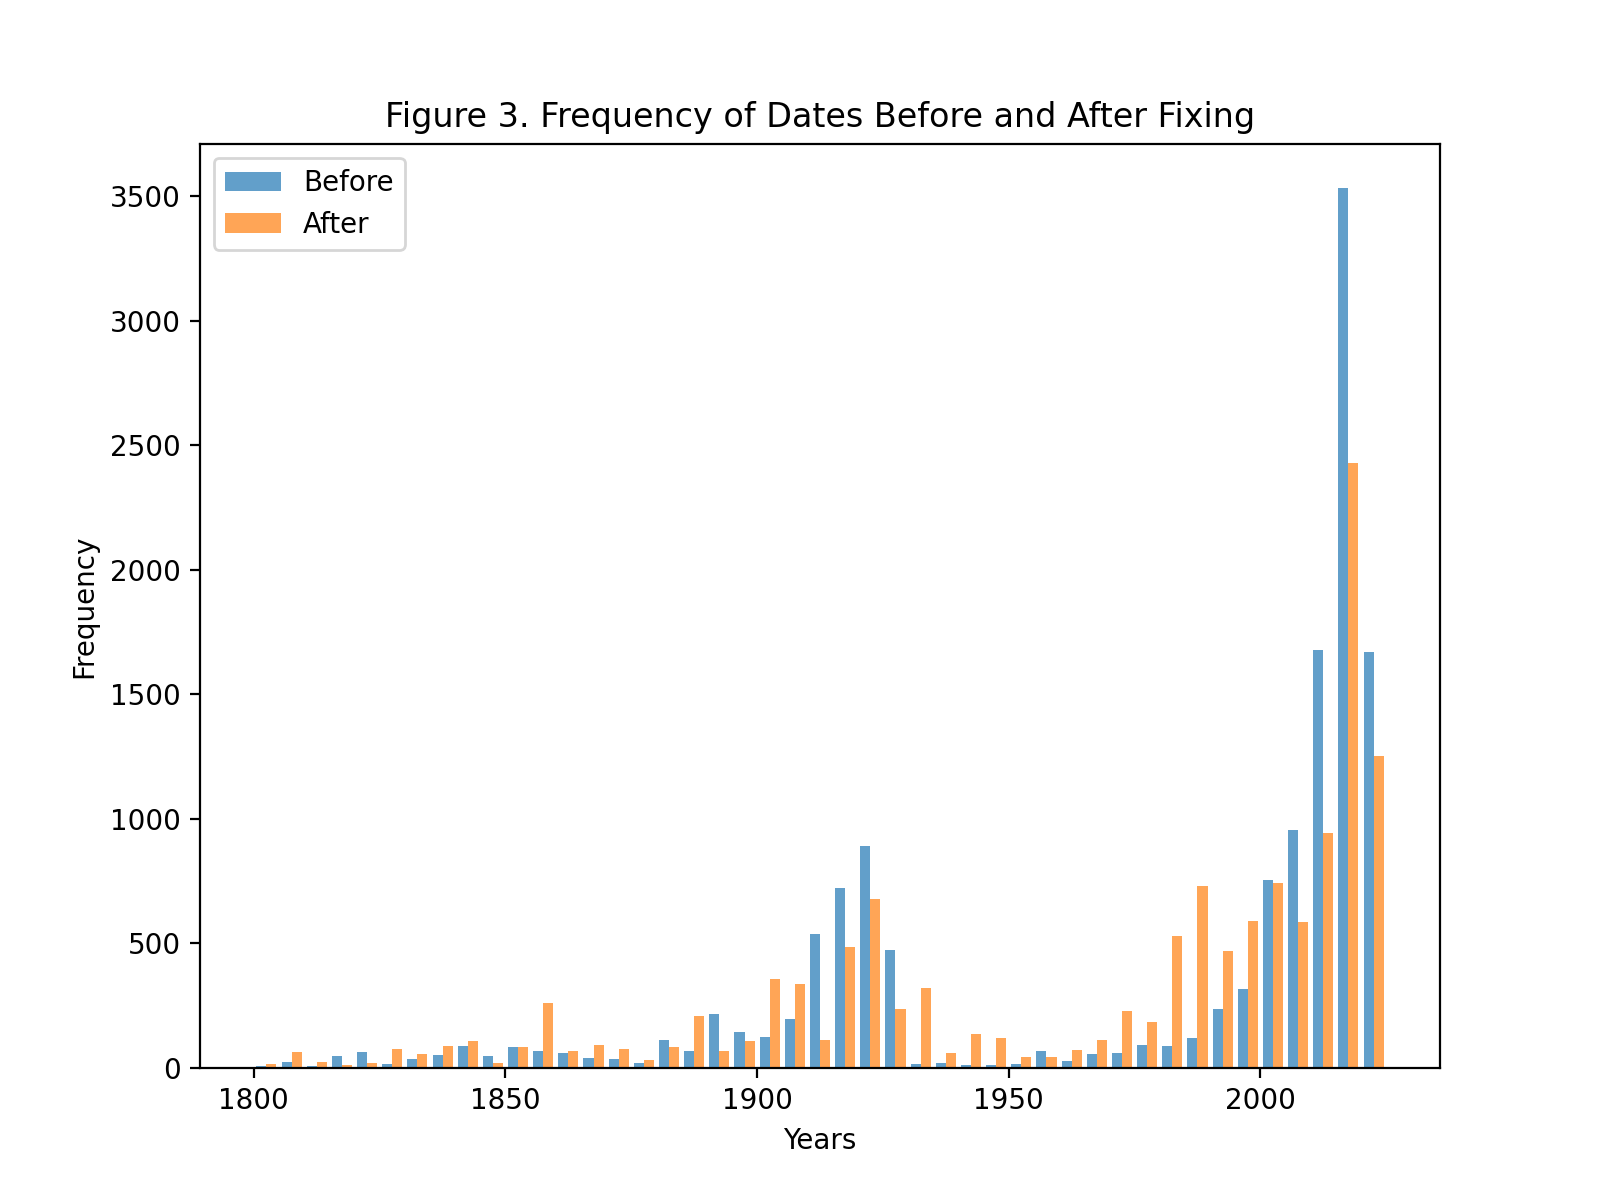

In [105]:

response = requests.get('https://raw.githubusercontent.com/AlexanderSLin/Poetry-Analysis-Using-Python/main/cleanedDateDF')
cleanedDateDF = pd.read_csv(StringIO(response.text), lineterminator='\n')

# Concatenate 'Year' columns from both DataFrames into a single DataFrame
combined_dates = pd.concat([cleanedDF['Year'], cleanedDateDF['Year']])

# Plotting a histogram with more bins
plt.figure(figsize=(8, 6))

# Specify the bin edges manually for a more detailed distribution
bins = [i for i in range(1800, 2026, 5)]  # Example: Bins every 5 years from 1990 to 2025

plt.hist([cleanedDF['Year'], cleanedDateDF['Year']], bins=bins, alpha=0.7, label=['Before', 'After'])

plt.xlabel('Years')
plt.ylabel('Frequency')
plt.title('Figure 3. Frequency of Dates Before and After Fixing')
plt.legend()

plt.show()

# Structure Analysis

## Structute of the Scraped Data
Now that we have obtained a suitable data frame of poetry we will create visulizations of the data frame to get a feel for its contents. In Figure 4, we graphed the distribution of lengths of poems over the whole data set and in a interactive visulization where you can select the time period poems are published from. The visulizations of distribution of poem length and frequency for the entire data set clearly shows a distinct smooth bellcurve shape with a definate left skew. The highest frequency of poem lengths tends to fall around the 900 characters.


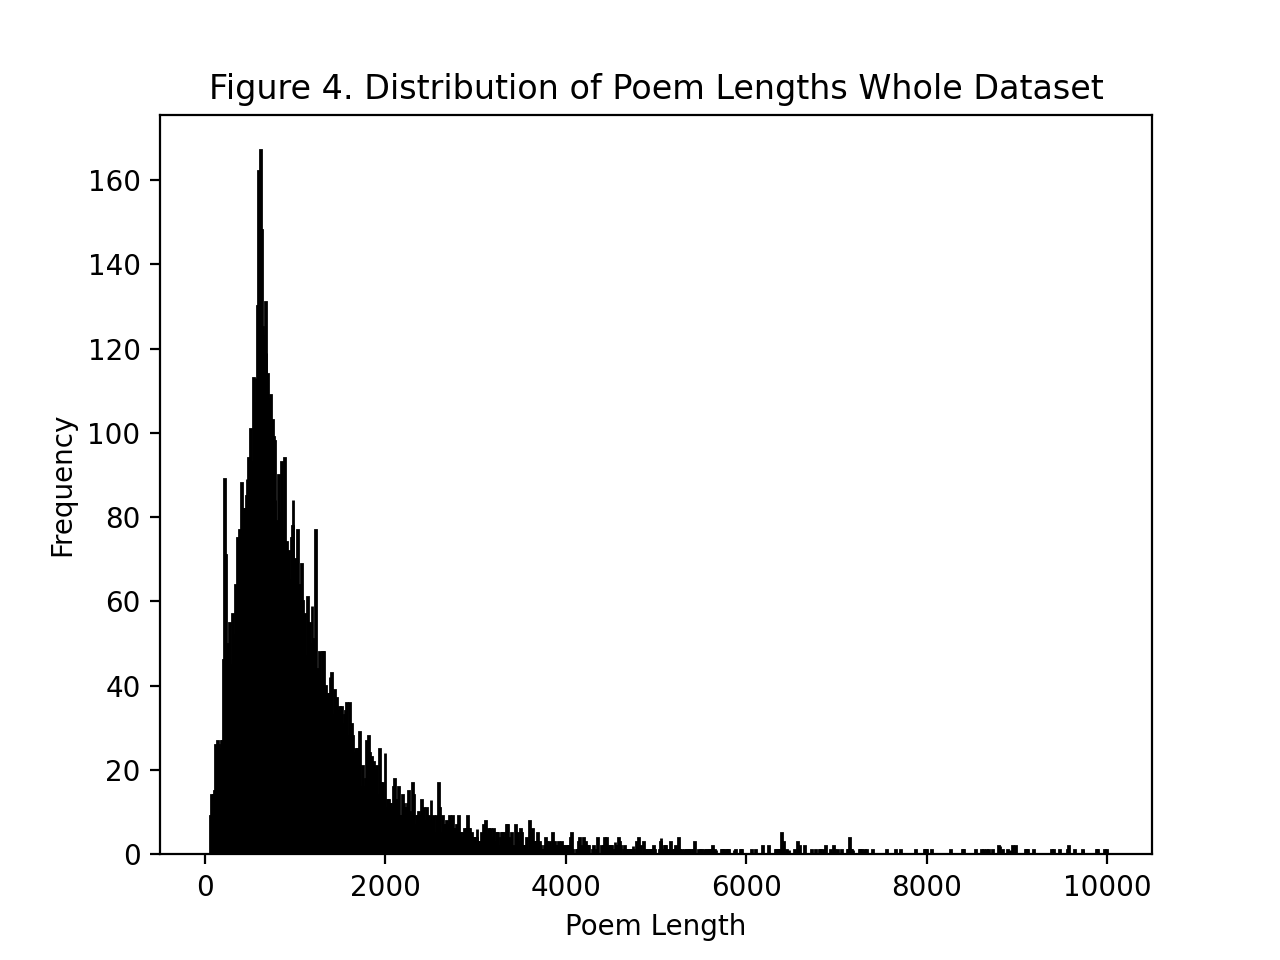

In [109]:
loaded_df['PoemLength'] = loaded_df['CleanedPoem'].apply(len)

# Plot the distribution with a specific x-axis range
plt.hist(loaded_df['PoemLength'], bins=1000, range=(0, 10000), color='skyblue', edgecolor='black')
plt.title('Figure 4. Distribution of Poem Lengths Whole Dataset')
plt.xlabel('Poem Length')
plt.ylabel('Frequency')
plt.show()

Figure 5. clearly shows that the data from each year also follows a bell shape with a left skew on average, however it is significantly less smooth and varies far more. Please note this interactive plot shows the probability density of each poem length rather than the max frequincy because the number of poems varies widly between years but the max probability stays roughly the same. For this reason choosing to display the probabilty density makes the plot far more consistent.

In [110]:

loaded_df['PoemLength'] = loaded_df['CleanedPoem'].apply(len)

def update_plot(start_year, end_year):
    filtered_df = loaded_df[(loaded_df['Year'] >= start_year) & (loaded_df['Year'] <= end_year)]

    # Plot the histogram
    plt.hist(filtered_df['PoemLength'], bins=1000, range=(0, 5000), color='skyblue', edgecolor='black', density=True, label='Poem Lengths')

    # Add labels and legend
    plt.title('Figure 5. Distribution of Poem Lengths By Period')
    plt.xlabel('Poem Length')
    plt.ylabel('Probability Density')
    plt.legend()

    plt.show()

start_year_input = widgets.IntText(value=loaded_df['Year'].min(), description='Start Year:')
end_year_input = widgets.IntText(value=loaded_df['Year'].max(), description='End Year:')

# Create an interactive plot
interact(update_plot, start_year=start_year_input, end_year=end_year_input)


interactive(children=(IntText(value=22, description='Start Year:'), IntText(value=2024, description='End Year:…

<function __main__.update_plot(start_year, end_year)>

Figure 6 shows the graph of percentiles and it shows how the majority of poems were writen by a minority of authors. The top ten percent of authors in terms of total titles make over 50 percent of the total poetry, which means in our trend analysis by author, we will not be able to show the trends of all authors equally.
In Figure 7, the plot above shows how there are a small number of authors who contribute the vast majority of the data. The 90th to 100th percentile of total titles per author has authors who had 10 to 180 poems. Since our data set is 1300 poems long, it can be seen that some authors were more highly represented than others.

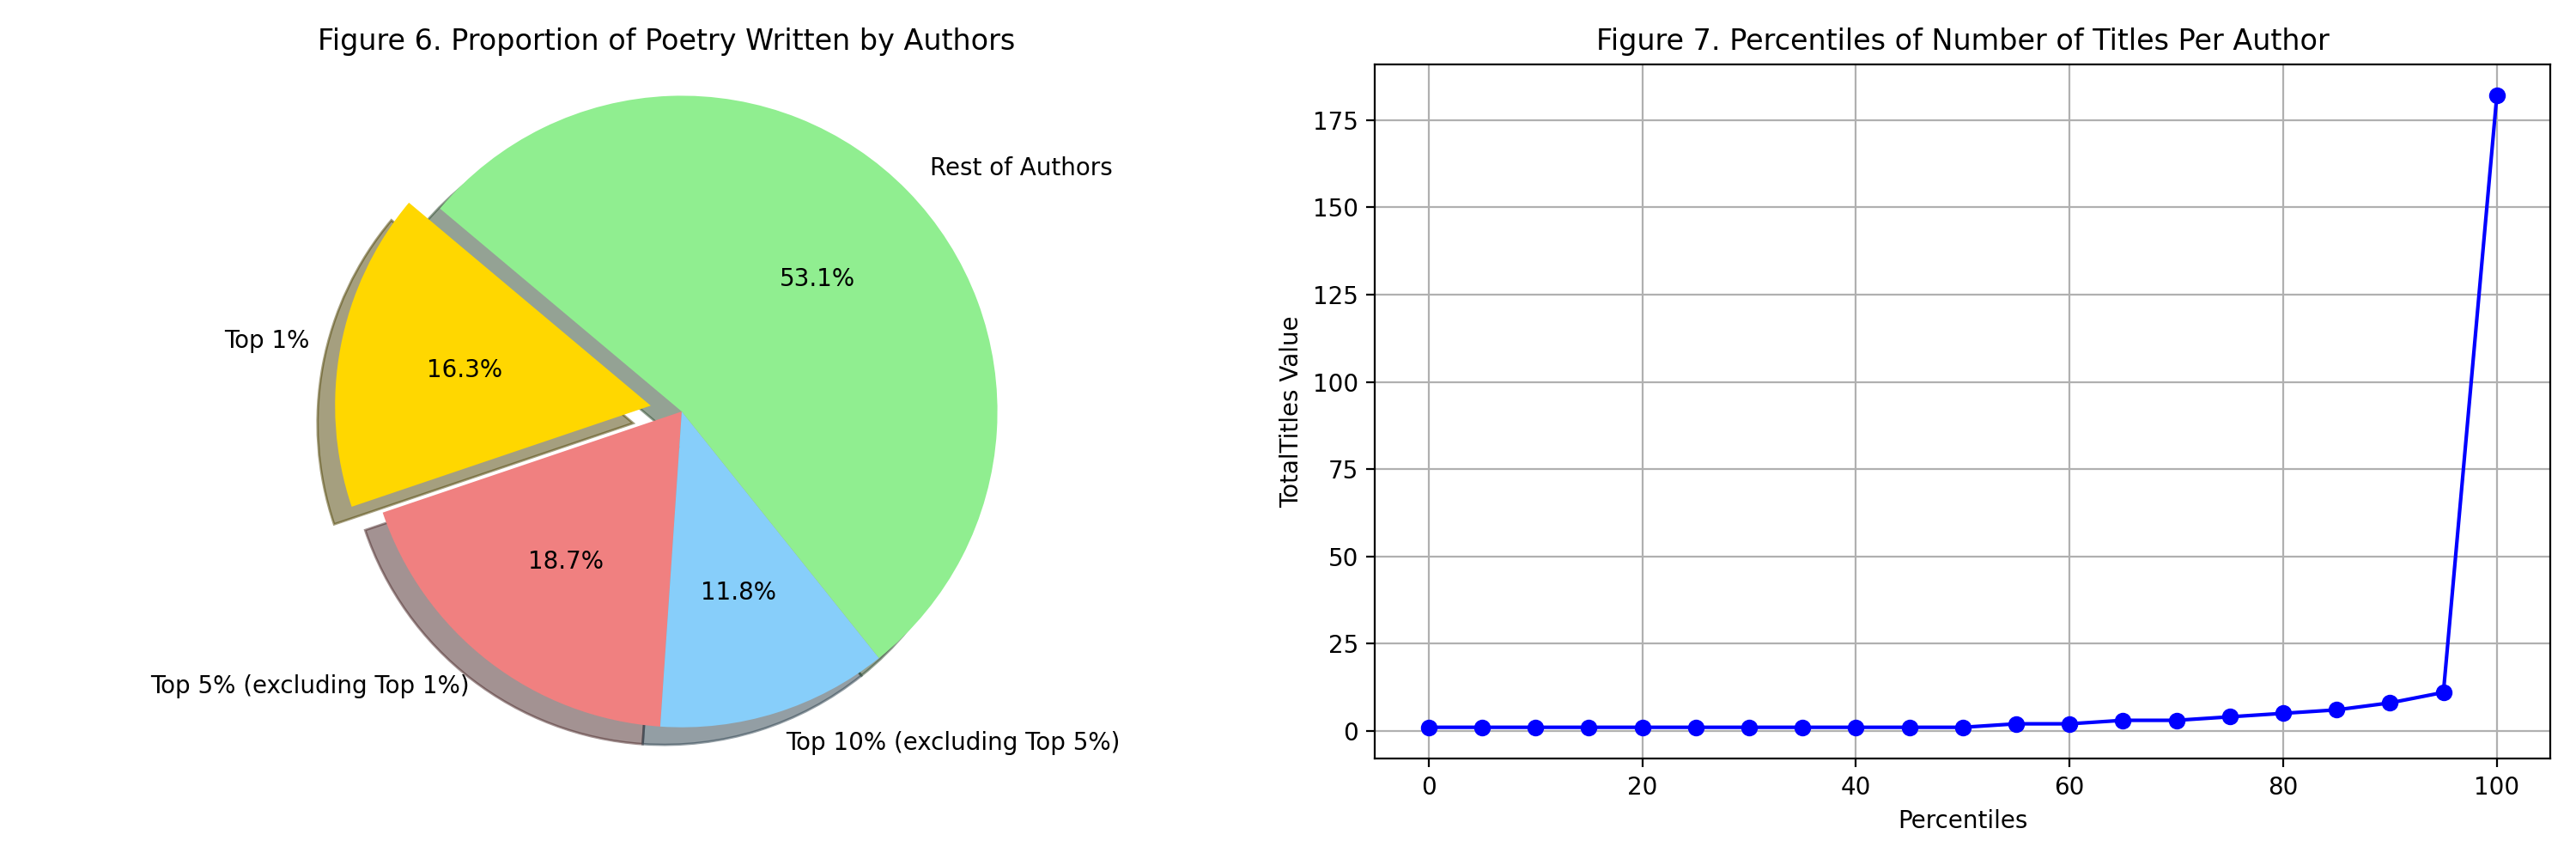

In [111]:
grouped_df = loaded_df.groupby('Author').agg({
    'Title': lambda x: list(x),
    'Year': lambda x: list(x),
    'Poem': lambda x: list(x)
}).reset_index()

grouped_df['TotalTitles'] = grouped_df['Title'].apply(len)

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 5))  # Adjust the figure size as needed

# ------------------- Pie Chart -------------------

# Calculate proportions for the pie chart
total_titles = grouped_df['TotalTitles'].sum()
percentile_1 = np.percentile(grouped_df['TotalTitles'], 99)
percentile_5 = np.percentile(grouped_df['TotalTitles'], 95)
percentile_10 = np.percentile(grouped_df['TotalTitles'], 90)

top_1_percent_titles = grouped_df[grouped_df['TotalTitles'] >= percentile_1]['TotalTitles'].sum()
top_5_percent_titles = grouped_df[grouped_df['TotalTitles'] >= percentile_5]['TotalTitles'].sum() - top_1_percent_titles
top_10_percent_titles = grouped_df[grouped_df['TotalTitles'] >= percentile_10]['TotalTitles'].sum() - top_5_percent_titles - top_1_percent_titles
rest_of_authors_titles = total_titles - top_10_percent_titles - top_5_percent_titles - top_1_percent_titles

# Pie chart
labels = ['Top 1%', 'Top 5% (excluding Top 1%)', 'Top 10% (excluding Top 5%)', 'Rest of Authors']
sizes = [top_1_percent_titles, top_5_percent_titles, top_10_percent_titles, rest_of_authors_titles]
colors = ['gold', 'lightcoral', 'lightskyblue', 'lightgreen']
explode = (0.1, 0, 0, 0)  # explode 1st slice

axes[0].pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
axes[0].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
axes[0].set_title('Figure 6. Proportion of Poetry Written by Authors')

# ------------------- Percentiles Line Chart -------------------

# Calculate percentiles and create a line chart
percentiles = np.arange(0, 101, 5)
percentiles_values = np.percentile(grouped_df['TotalTitles'], percentiles)

axes[1].plot(percentiles, percentiles_values, marker='o', linestyle='-', color='b')
axes[1].set_xlabel('Percentiles')
axes[1].set_ylabel('TotalTitles Value')
axes[1].set_title('Figure 7. Percentiles of Number of Titles Per Author')
axes[1].grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()


## Rhyming

Figure 8. shows a histogram of the number of lines per poem and it shows some interesting trends. The distribution of poem lines is significantly different than the distribution of lengths, although both are left skewed. Figure 4. has a disproportionate amount of poems at specific numbers of lines. This is cause by specific formating for poetry bing very popular, like haveing stnazas of 4 lines, resulting in a poem with a multiple of 4 lines, or the spike at 14 lines which is caused by the popularity of sonnets, which have 14 lines.

In [190]:
response = requests.get('https://raw.githubusercontent.com/AlexanderSLin/Poetry-Analysis-Using-Python/main/cleanedDateDF')
CleanedPoem = pd.read_csv(StringIO(response.text), lineterminator='\n')

response = requests.get('https://raw.githubusercontent.com/AlexanderSLin/Poetry-Analysis-Using-Python/main/poemLinesDF')
poemLines = pd.read_csv(StringIO(response.text), lineterminator='\n')

response = requests.get('https://raw.githubusercontent.com/AlexanderSLin/Poetry-Analysis-Using-Python/main/newComplete')
new_df = pd.read_csv(StringIO(response.text), lineterminator='\n')

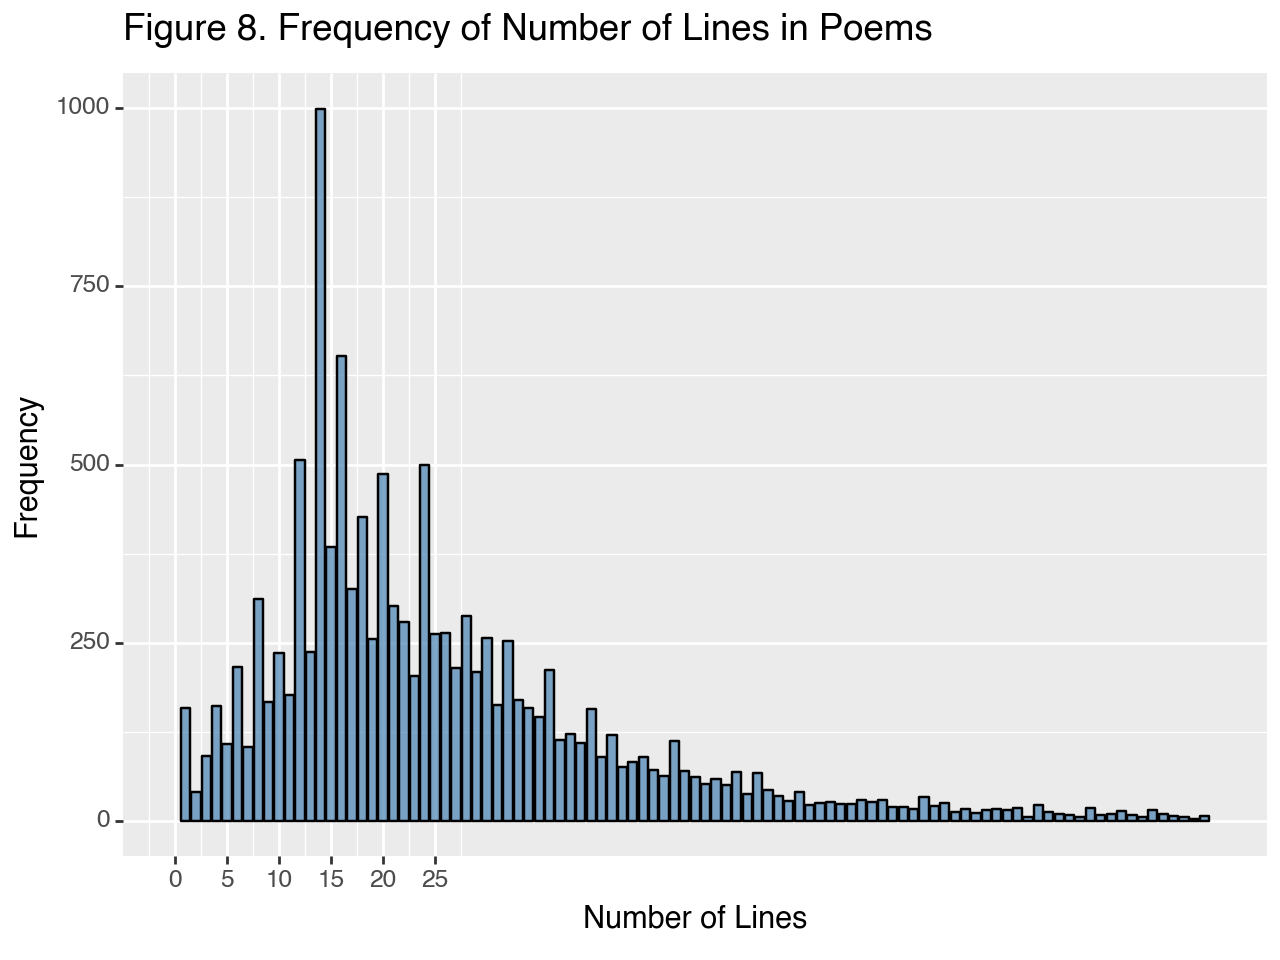

In [184]:
def count_lines_per_poem(poetry_df):
    # Group by 'Title' and 'Author' and count the number of lines in each poem
    lines_count_per_poem = poetry_df.groupby(['Title', 'Author'])['Line'].count().reset_index()

    return lines_count_per_poem
poem_lines_sum = count_lines_per_poem(poemLines)
new_df = pd.merge(poem_lines_sum, CleanedPoem, on=['Title', 'Author'], how='inner')

line_frequency_plot = (
    ggplot(new_df, aes(x='Line'))
    + geom_bar(stat='count', fill='steelblue', color='black', alpha=0.7)
    + ggtitle('Figure 8. Frequency of Number of Lines in Poems')
    + xlab('Number of Lines')
    + ylab('Frequency')
    + scale_x_continuous(limits=(0, 100), breaks=list(range(0, 26, 5)))
)
warnings.filterwarnings("ignore")
print(line_frequency_plot)

Figure 9 indicates a strong positve correlation between poem length and rhyming word count. This is because there is a random chance of any two words rhyming together of .47 according to our data. In poetry rhyming is often intentional, however when you are checking more words to see if they rhyme you are bound to find rhyming pairs that were not intentional. The longer the poem, the larger the probability rhyming is unintentional. If you are trying to measure how rhyming a poem is it is important to acount for this.

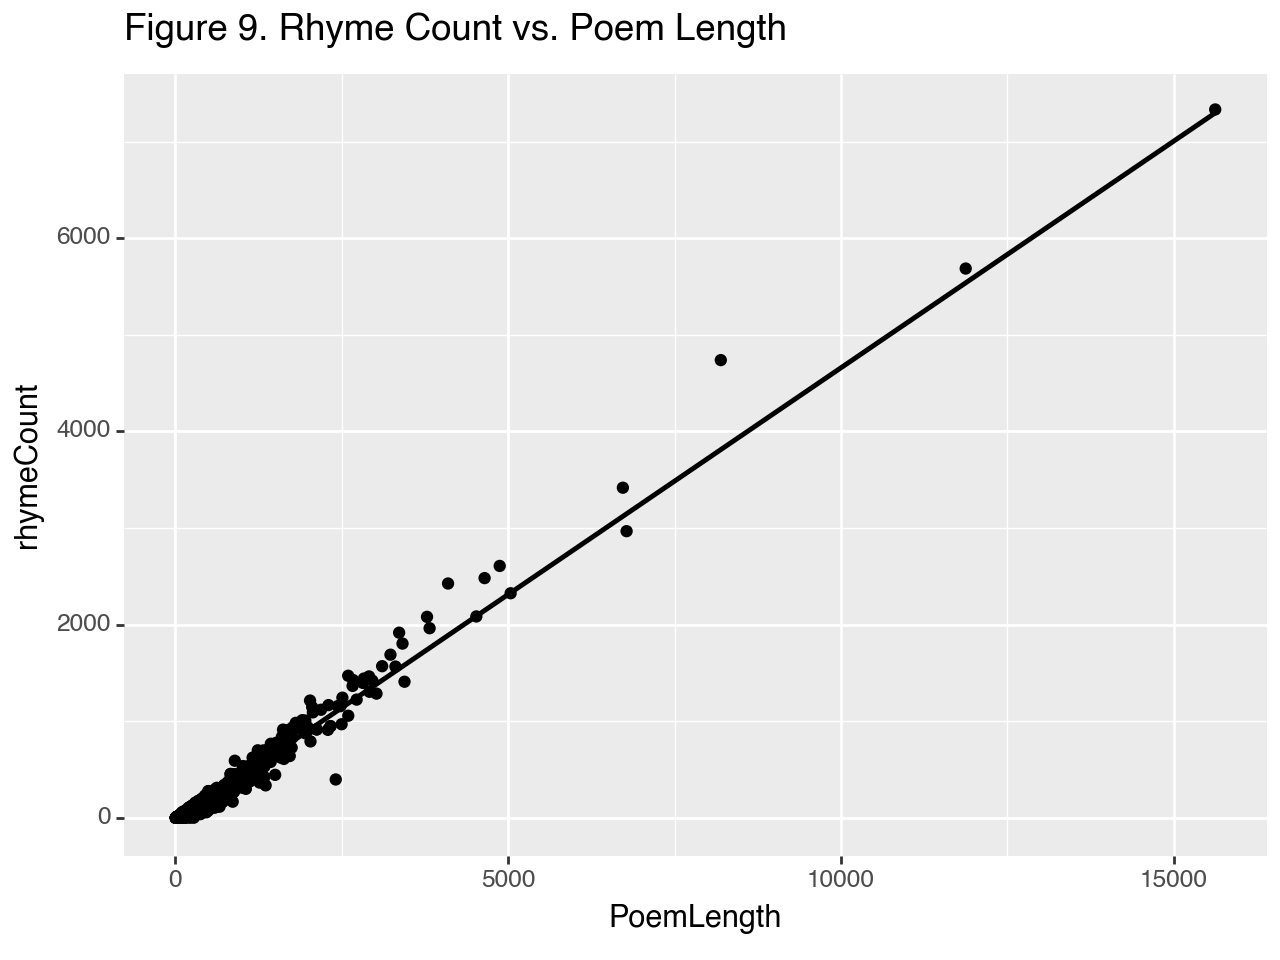


Slope: 0.46943904764870636
R-value: 0.9843099715875494


In [183]:
response = requests.get('https://raw.githubusercontent.com/AlexanderSLin/Poetry-Analysis-Using-Python/main/rhymeCountsDF')
new_df1 = pd.read_csv(StringIO(response.text), lineterminator='\n')

# Create a scatter plot with a regression line
rhymes_length = (
    ggplot(new_df1, aes(x='PoemLength', y='rhymeCount'))
    + geom_point()
    + geom_smooth(method='lm', se=False)  # 'lm' stands for linear model
    + ggtitle('Figure 9. Rhyme Count vs. Poem Length')
)

# Show the plot
print(rhymes_length)

# Extract and display the slope and R-value
slope, intercept, r_value, p_value, std_err = linregress(new_df1['PoemLength'], new_df1['rhymeCount'])

print(f"Slope: {slope}")
print(f"R-value: {r_value}")

Another approach to measuring rhyming in a poem is to caluculate the rhymes per line in a poem. This provides a more structural view of a poam as it describes a rhyming relationship lines over all instead of words. Figure 10 shows the graph of rhymes per word in a poem and it shows many interesting characteristics. One is the spread of values decreases as the length of the poems increases. Additionally if decrease the opacity of the points you will see the data is concentrated around a narower range. Furthermore the rhymes per word ration seems to approach an asymptote as the length increases. The rate of change also decreases as the poem length increases. All of these characteristics illustrates how a this metric of rhyming looses its ability to intentionaly make a poem rhyme more or less decreases as the length of the poem increases. For this reason this metric is only good when poem length is short. As this metric of rhyming consider the entirity of the poem it allows you to measure how much a poem rhymes over all.

In [188]:
new_df.head()


,Title,Author,Line,Year,Poem,CleanedPoem,PoemLength,Period,TopNEmotions,TopNWords
0,"""A hundred thousand million mites we go""",Charles Hamilton Sorley,24,1905,A hundred thousand million mites we go\nWheel...,A hundred thousand million mites we go Wh...,1204,Period 10,['fear' 'approval' 'annoyance'],"['forth', 'blindness', 'hundred', 'eternal', '..."
1,"""All Puffy and White, Goldish, Harpy, and Ange...",Lance Larsen,1,2017,This the neighbor boy’s exact description of ...,This the neighbor boy s exact description of h...,862,Period 10,['approval' 'anger' 'disgust'],"['sled', 'week', 'fists', 'seasoned', 'smiley'..."
2,"""Also Birds"" [excerpt]",Dawn Lundy Martin,13,2011,"Here, a description of stalemate looking past ...","Here, a description of stalemate looking past ...",940,Period 10,['optimism' 'curiosity' 'approval'],"['thermal', 'fisherman', 'preparations', 'sunl..."
3,"""An Insistent and Eager Harmoniousness to Things""",David Keplinger,8,2011,—David Abram Like an enormous...,David Abram Like an enormous leech the pancrea...,501,Period 10,['disapproval' 'annoyance' 'approval'],"['unconscious', 'turn', 'completely', 'reverti..."
4,"""Bobs""",Jessie Pope,16,1904,"The call came in the stormy night,\n Benea...","The call came in the stormy night, Be...",628,Period 10,['admiration' 'approval' 'annoyance'],"['his', 'dust', 'ours', 'soul', 'marching', 'b..."


In [191]:
# Get unique authors and assign a color to each
unique_authors = new_df['Author'].unique()
author_colors = {author: f'rgba({i * 30 % 255}, {i * 40 % 255}, {i * 50 % 255}, 0.7)' for i, author in enumerate(unique_authors)}

# Create an interactive scatter plot with opacity and year range input boxes
def plot_scatter_opacity_color_year_range(df, opacity, min_year, max_year):
    fig = go.Figure()

    for author, color in author_colors.items():
        author_df = df[df['Author'] == author]
        year_range_df = author_df[(author_df['Year'] >= min_year) & (author_df['Year'] <= max_year)]
        scatter = go.Scatter(
            x=year_range_df['PoemLength'],
            y=year_range_df['RhymesPerWord'],
            mode='markers',
            marker=dict(
                size=4,
                opacity=opacity,
                color=color
            ),
            showlegend=False  # Do not include legend for each author
        )
        fig.add_trace(scatter)

    fig.update_layout(
        title=f'Figure 10. Scatter Plot with Opacity Slider (Year Range: {min_year}-{max_year})',
        xaxis=dict(title='Poem Length'),
        yaxis=dict(title='Rhymes Per Word'),
    )

    fig.show()

# Use the interact function to create input boxes for opacity and year range
interact(
    plot_scatter_opacity_color_year_range,
    df=widgets.fixed(new_df),
    opacity=widgets.FloatSlider(min=0.01, max=1.0, step=0.01, value=0.5),
    min_year=widgets.BoundedIntText(min=new_df['Year'].min(), max=new_df['Year'].max() - 1, step=1, value=new_df['Year'].min(), description='Min Year:'),
    max_year=widgets.BoundedIntText(min=new_df['Year'].min() + 1, max=new_df['Year'].max(), step=1, value=new_df['Year'].max(), description='Max Year:')
)


interactive(children=(FloatSlider(value=0.5, description='opacity', max=1.0, min=0.01, step=0.01), BoundedIntT…

<function __main__.plot_scatter_opacity_color_year_range(df, opacity, min_year, max_year)>

In [199]:
import plotly.io as pio
import orca

# Ensure the plotly package is installed with the Orca engine enabled
pio.orca.config.executable = '/path/to/your/orca/executable'  # Provide the path to your Orca executable

# Get unique authors and assign a color to each
unique_authors = new_df['Author'].unique()
author_colors = {author: f'rgba({i * 30 % 255}, {i * 40 % 255}, {i * 50 % 255}, 0.7)' for i, author in enumerate(unique_authors)}

# Filter the DataFrame based on the year range
min_year = new_df['Year'].min()
max_year = new_df['Year'].max()
year_range_df = new_df[(new_df['Year'] >= min_year) & (new_df['Year'] <= max_year)]

# Create a static scatter plot
fig = px.scatter(
    year_range_df,
    x='PoemLength',
    y='RhymesPerWord',
    color='Author',
    opacity=0.5,  # Set the opacity here
    color_discrete_map=author_colors,  # Use the predefined author colors
    labels={'PoemLength': 'Poem Length', 'RhymesPerWord': 'Rhymes Per Word'},
    title=f'Scatter Plot with Opacity (Year Range: {min_year}-{max_year})'
)

fig.update_traces(marker=dict(size=4))

# Save the scatter plot as a PNG image using Orca engine
fig.write_image('static_scatter_plot.png', engine='orca')


ModuleNotFoundError: No module named 'orca'

The violin plots in Figure 11. show the distribution of rhymes per word per year are largely the same over time. Although they vary year to year the locations of the median, third and first Quartiles remain largely the same, as does the shape of the distribution. This is more true in years with more data. This indicates that rhyming occurance overall has not changed over time. The more blue a violin plot is the more data came from that year.

In [128]:
def plot_scatter(selected_df, start_year):
    end_year = start_year + 9
    filtered_df = selected_df[(selected_df['Year'] >= start_year) & (selected_df['Year'] <= end_year)]

    # Create a violin plot for each year with color determined by 'PercentageByYear'
    violin_traces = []
    for year in range(start_year, end_year + 1):
        year_data = filtered_df[filtered_df['Year'] == year]

        # Skip processing if the DataFrame for the current year is empty
        if year_data.empty:
            continue

        violin_data = year_data['RhymesPerWord']
        percentage_by_year = round(year_data['PercentageByYear'].iloc[0], 3)  # Assuming 'PercentageByYear' is constant for the year
        num_poems = len(year_data)

        # Calculate the color based on 'PercentageByYear'
        fill_color = f'rgba(0, 0, 255, {percentage_by_year / 9})'  # Adjust the scale based on the range [0, 9]

        violin_trace = go.Violin(
            y=violin_data,
            box_visible=True,
            fillcolor=fill_color,
            line_color='black',  # Set the outlines to black
            line_width=2,  # Adjust the line width
            name=f'Year {year} - {num_poems} Poems, {percentage_by_year} %'
        )
        violin_traces.append(violin_trace)

    # Create layout
    layout = go.Layout(
        title=f"Figure 11. Rhyme Rating per Line for Years {start_year}-{end_year}",
        xaxis=dict(title="Year"),
        yaxis=dict(title="Rhyme Rating per Line"),
        showlegend=False
    )

    # Create figure
    fig = go.Figure(data=violin_traces, layout=layout)

    # Show figure
    fig.show()

# Use the interact function to create a slider for the start year
interact(
    plot_scatter,
    selected_df=widgets.fixed(new_df),
    start_year=widgets.IntSlider(min=new_df['Year'].min(), max=new_df['Year'].max() - 9, step=1, value=new_df['Year'].min())
)


interactive(children=(IntSlider(value=1000, description='start_year', max=2014, min=1000), Output()), _dom_cla…

<function __main__.plot_scatter(selected_df, start_year)>

To combat measure the amount of rhyming in a poem and minimize the effect of unintentional rhyming it a good approach is to acount for the structure of a poem. Poems are broken into lines which are often broken into groups of lines. Rhymes in a given line groups of lines are general very intentional as the author will either select rhyming words close to each other to make the poem read in a specific way. Likewise if the author does not want the poem to rhym they will select words that do not rhyme in lines close to each other. Below(Figure 12) is a graph that displays the total number of rhyming words on the x axis and number of lines compared in 10 randomly selected poems. each color is a diferent poem. You can select the range of words you want the graph to display.

In [147]:
# Identify numerical columns (excluding the last two columns)
completeNewLines = new_df
numerical_columns = completeNewLines.iloc[:, 2:24].select_dtypes(include=[np.number]).columns

# Function to create a graph with selected random data points
def plot_random_data_points(min_words, max_words):
    # Select rows within the specified range of PoemLength
    selected_rows = completeNewLines[
        (completeNewLines['PoemLength'] >= min_words) & (completeNewLines['PoemLength'] <= max_words)
    ]

    # Select a random subset of 20 data points
    random_sample = selected_rows.sample(n=min(10, len(selected_rows)))

    # Create a plot
    plt.figure(figsize=(10, 6))

    # Plot each selected row with a different color
    for idx, row_idx in enumerate(random_sample.index):
        # Exclude the last two columns from row_data
        row_data = completeNewLines.iloc[row_idx, 2:24][numerical_columns].reset_index(drop=True)
        plt.plot(row_data.index, row_data.values, label=f'Row {row_idx}', marker='o')

    # Customize the plot
    plt.xlabel('Column Number')
    plt.ylabel('Numerical Value')
    plt.title('Figure 12. Random Data Points from newLinesRhyme')

    # Remove the legend
    plt.legend().set_visible(False)

    # Set numerical labels on the x-axis
    plt.xticks(np.arange(0, 24), np.arange(1, 25))  # Update to match the number of ticks and labels

    # Show the plot
    plt.show()

# Create interactive widgets for user input
min_words_widget = widgets.IntText(value=completeNewLines['PoemLength'].min(), description='Min Words')
max_words_widget = widgets.IntText(value=completeNewLines['PoemLength'].max(), description='Max Words')

# Create an interactive widget to trigger the plot
interact(plot_random_data_points, min_words=min_words_widget, max_words=max_words_widget)

interactive(children=(IntText(value=7, description='Min Words'), IntText(value=15621, description='Max Words')…

<function __main__.plot_random_data_points(min_words, max_words)>

A common trend across in these plots is for the number of sum rhyming words to increase as you count between more lines and then remain constant once all the group of lines being measured exceeds the number of lines in the poem. as the number of lines increases the likelyhood of unintentional rhyming also increases. For this reason measurments of fewer lines are more accurate, however they are unable to detect intentional rhyming outside of the give line range. For this reason I would say the best metric of rhyming would be rhymes between 4 lines, as most poems have lines in groups of 4 and if author is making rhyming poem they will most often focus on making words in each group line. This allows for the most rhyming to be acounted for between lines while not allowing a high probability of unintentional rhymes.

# Structure of the Poems Themselves.

## Subject and Emotions Analysis

We chose to dive into what each poem has to say by trying to identify data on what the poem actually means. How does it make a reader feel? What is it about? The goal of this was to answer the question of how has poetry, and the English language changed over time. These were the features that would show these desired trends.

* Sentiment Analysis by Subjectivity and Polarity
* Logistic Regression Model To Identify Emotion
* Subject Prediction
 *  Stop Word Set
 *  Word Frequency to Predict the Unique Subject


### Creating Features to Describe Meaning
##### Each data point is a poem, and author and a year. We wanted to make meaningful data points from the poem describing the subject and the emotions the poem involed.

In [98]:


def identify_specific_emotions_textblob(poem, n=3):
    # Create a TextBlob object
    blob = TextBlob(poem)

    # Get the sentiment polarity and subjectivity
    sentiment_polarity = blob.sentiment.polarity
    sentiment_subjectivity = blob.sentiment.subjectivity

    # Return the sentiment polarity and subjectivity
    return sentiment_polarity, sentiment_subjectivity

# Example usage:
poem_example = "The sun shines brightly in the clear blue sky. A storm is brewing on the horizon, bringing darkness and rain."
print(poem_example)
result = identify_specific_emotions_textblob(poem_example)
print("Sentiment Polarity:", result[0])
print("Sentiment Subjectivity:", result[1])


Sentiment Polarity: 0.26666666666666666
Sentiment Subjectivity: 0.42777777777777776


When trying to get data about the meaning of the poetry itself, we used a basic approach first. Basic emotion detection models could say things like positive, negative or neutral for emotion, but we wanted to get more specific. Subjectivity measures how factural verus opionated something is and polarit measures how good or bad the feelings are toward something. As you can see, our test text ranked much higher in subjectivity than polarity. Polarity is measured negative one to one with negative one being totally bad and 1 being totally good. As you can see polarity for the test text was .27, which  tells us that the author felt slightly good abot the subject.

## Emotion Identification Logistical Model Training
Using the Go Emotions dataset and  the ISear dataset for emotion identification, we were able to identify the emotions in the poetry. Isear was created by the university of Geneva for this very purpose of helping to create language models. People were given seven emotions to chose from for certain situations and the data set was created, to train your own emotion identification model. The Go Emotions data set had 27 emotions taken from reactioons to various tweet. We combined these into a total data set of 250,000 total text and their related top emotion. Then I decided to use a Logistic Regression on the data since the other ones were taking a lot longer to train. I was going to use a machine learning model instead, but it was taking a lot longer to train and the glm had similar accuracy. The GLM had a correct emotion prediction for the 250,000 text of about .4 meaning out of 27 emotions, it got the right one almost 40 percent of the time. We were satisfied with that, so we took the vectoizer that was used to turn the text into word vectors and the model itself and saved them as files, so that we could identify the subject and emotions in all our poems. Again we used the saved models and loaded them in to save ourselves time. 

## Stopwords
When identifying the subject of the poem, we wanted to be specific. The subject should be descriptive, so we wanted to remove words that would construe the real subject such as the, and, at, those, and other important contractions. To identify the subject, we used the word tokenization, to create word frequency diagrams, then we used that word tokenization and vectorization to gauge which words were being described by the emotion, and this helped identify the possible subject. Stopwords could be interactively added, and stored in a csv file with a user input. This was nice, so we could run the code and see if we needed to remove more stopwords since they were too broad. When identifying the subject, we simply took the top words that described the poem, without the stopwords. Below, the stopwords that were removed can be seen in Figure 13.


In [153]:
Stopword_List = ['the', 'that', 'ones', 'did', 'this', 'those', 'and', 'am', 'so', 'is', ',', '.', '!', '?', 'a', 'an', 'of', 'or', 'is', 'at', 'are', 'penis', 'the', 'that', 'ones', 'did', 'this', 'those', 'and', 'am', 'so', 'is', ',', '.', '!', '?', 'a', 'an', 'of', 'or', 'is', 'at', 'are', 'about', 'ah', 'all', 'also', 'another', 'any', "aren't", 'as', 'by', 'be', 'because', 'been', 'both', 'but', 'cause', 'come', 'comes', 'con', 'could', "didn't", 'do', 'does', "doesn't", 'doing', 'done', "don't", 'each', 'for', 'even', 'everything', 'from', 'get', 'go', 'goes', 'going', 'got', 'had', "hadn't", 'has', "hasn't", 'have', 'he', 'she', 'they', 'here', "here's", 'I', "I'd", "I'll", "I'm", 'in', 'it', "it's", "i've", 'just', 'no', 'know', 'let', "let's", 'lets', 'like', 'look', 'made', 'make', 'many', 'may', '', 'me', 'might', 'mine', 'most', 'more', 'much', 'must', 'my', 'need', 'nor', 'not', 'ok', 'okay', 'on', 'one', 'onto', 'other', 'our', 'out', 'over', 'per', 'plus', 'put', 'said', 'same', 'saw', 'seen', 'hey', 'hm', 'should', 'show', 'side', 'since', 'some', 'soon', 'sub', 'stop', 'such', 'take', 'tell', 'then', 'than', 'there', 'their', 'them', 'thing', 'though', 'thus', 'through', 'till', 'to', 'too', 'took', 'top', 'toward', 'try', 'under', 'until', 'up', 'us', 'use', 'used', 'very', 'want', 'was', 'way', 'we', 'well', 'where', 'were', 'what', 'when', 'which', 'while', 'who', 'whole', 'whose', 'why', 'will', "won't", 'ydeds', 'yes', 'you', "you're", 'yours', 'the', 'that', 'ones', 'did', 'this', 'those', 'and', 'am', 'so', 'is', ',', '.', '!', '?', 'a', 'an', 'of', 'or', 'is', 'at', 'are', 'poem', 'click', 'audio', 'link', 'visual', 'html', 'tag', 'video', 'plp', 'icon', 'click', 'video', 'icon']
print(f"{'Figure 13.'} \n \n{Stopword_List}")


Figure 13. 
 
['the', 'that', 'ones', 'did', 'this', 'those', 'and', 'am', 'so', 'is', ',', '.', '!', '?', 'a', 'an', 'of', 'or', 'is', 'at', 'are', 'penis', 'the', 'that', 'ones', 'did', 'this', 'those', 'and', 'am', 'so', 'is', ',', '.', '!', '?', 'a', 'an', 'of', 'or', 'is', 'at', 'are', 'about', 'ah', 'all', 'also', 'another', 'any', "aren't", 'as', 'by', 'be', 'because', 'been', 'both', 'but', 'cause', 'come', 'comes', 'con', 'could', "didn't", 'do', 'does', "doesn't", 'doing', 'done', "don't", 'each', 'for', 'even', 'everything', 'from', 'get', 'go', 'goes', 'going', 'got', 'had', "hadn't", 'has', "hasn't", 'have', 'he', 'she', 'they', 'here', "here's", 'I', "I'd", "I'll", "I'm", 'in', 'it', "it's", "i've", 'just', 'no', 'know', 'let', "let's", 'lets', 'like', 'look', 'made', 'make', 'many', 'may', '', 'me', 'might', 'mine', 'most', 'more', 'much', 'must', 'my', 'need', 'nor', 'not', 'ok', 'okay', 'on', 'one', 'onto', 'other', 'our', 'out', 'over', 'per', 'plus', 'put', 'said', '

## Word Clouds
To diplay common emotions and also common subjects within poems, we chose to use word clouds. Words that were used more of emotions that appeared more will look larger on the graph. Similar to a word frequency diagram, a word cloud more effectively shows the reader what the frequency was of different words and emotions. Figure 14 shows the top N emotions for an author, Figure 15 shows the top N emotions for a year range, Figure 16 shows the top N words for an author, and Figure 17 shows the top N words for a year range.

In [156]:
#Correct Placement Word Cloud ONe


def update_word_cloud(author_name, top_n_words):
    # Select data for the chosen author
    author_data = cleaned_df[cleaned_df['Author'] == author_name]

    # Combine the top words for the selected author
    # Assuming 'TopNEmotions' column contains lists of strings
    #top_words_list = [word.strip("' ") for words_list in author_data['TopNEmotions'] for word in ' '.join(words_list).split("' '")]
    #top_words_list = top_words_list[:top_n_words]

    all_words = [word.strip("' ") for words_list in author_data['TopNEmotions'] for word in ' '.join(words_list).split("' ")]

    # Count the occurrences of each word
    word_counts = Counter(all_words)

    # Extract the top N words
    top_words_list = [word for word, count in word_counts.most_common(top_n_words)]
    # Generate word cloud
    top_words_text = ' '.join(top_words_list)

    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(top_words_text)

    # Plot the word cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Figure 14. Top {top_n_words} Emotion Cloud for Author: {author_name}')
    plt.show()

# List of unique author names
author_names = cleaned_df['Author'].unique()

# Autocomplete widget for author name input
author_autocomplete = widgets.Dropdown(
    options=author_names,
    value=author_names[0],  # Set the default value to the first option
    description='Author Name:',
    disabled=False
)

# Text widget for top N words input
top_n_words_input = widgets.IntText(
    value=10,
    description='Top N Words:',
    disabled=False
)

# Display the widget
# Interaction with the widgets
widgets.interactive(update_word_cloud, author_name=author_autocomplete, top_n_words=top_n_words_input)



interactive(children=(Dropdown(description='Author Name:', options=('Charles Bukowski', 'Dylan Thomas', 'Willi…

In [158]:
#Correct Placement Word Cloud 2

# Function to update the word cloud based on the selected year and top n words
def update_word_cloud(selected_year, top_n_words):
    # Define the century window (within 50 years above and below the slider)
    min_year = max(1000, selected_year - 50)
    max_year = min(2023, selected_year + 50)

    # Select data for the century window
    window_data = cleaned_df[(cleaned_df['Year'] >= min_year) & (cleaned_df['Year'] <= max_year)]

    # Combine the top words for the selected year
    all_words = [word.strip("' ") for words_list in window_data['TopNEmotions'] for word in ' '.join(words_list).split("' ")]

    # Count the occurrences of each word
    word_counts = Counter(all_words)

    # Extract the top N words
    top_words_list = [word for word, count in word_counts.most_common(top_n_words)]

    # Generate word cloud
    top_words_text = ' '.join(top_words_list)

    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(top_words_text)

    # Plot the word cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Figure 15. Top {top_n_words} Emotion Cloud for Years: {min_year} to {max_year}')
    plt.show()

# Slider widget
year_slider = widgets.IntSlider(
    value=cleaned_df['Year'].min(),
    min=1000,  # Restrict to years after 1000
    max=2023,
    step=1,
    description='Select Year:',
    disabled=False,
    continuous_update=False  # Set to False to update the word cloud only when the slider is released
)

# Text widget for specifying top n words
top_n_words_input = widgets.IntText(
    value=10,
    description='Top n Words:',
    disabled=False
)

# Display the slider and top n words input
# Interaction with the slider and top n words input
widgets.interactive(update_word_cloud, selected_year=year_slider, top_n_words=top_n_words_input)


interactive(children=(IntSlider(value=1000, continuous_update=False, description='Select Year:', max=2023, min…

In [161]:
#Correct Placement Word Cloud 3


# Function to update the word cloud based on the selected author and top N words
def update_word_cloud(author_name, top_n_words):
    # Select data for the chosen author
    author_data = cleaned_df[cleaned_df['Author'] == author_name]

    # Combine the top words for the selected author
    all_words = [word.strip("' ") for words_list in author_data['TopNWords'] for word in ' '.join(words_list).split("' ")]

    # Count the occurrences of each word
    word_counts = Counter(all_words)

    # Extract the top N words
    top_words_list = [word for word, count in word_counts.most_common(top_n_words)]

    # Generate word cloud
   # Generate word cloud
    top_words_text = ' '.join(top_words_list)
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(top_words_text)


    # Plot the word cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Figure 16. Top {top_n_words} Words Word Cloud for Author: {author_name}')
    plt.show()

# List of unique author names
author_names = cleaned_df['Author'].unique()

# Autocomplete widget for author name input
author_autocomplete = widgets.Dropdown(
    options=author_names,
    value=author_names[0],  # Set the default value to the first option
    description='Author Name:',
    disabled=False
)

# Text widget for top N words input
top_n_words_input = widgets.IntText(
    value=10,
    description='Top N Words:',
    disabled=False
)

# Display the widget
# Interaction with the widgets
widgets.interactive(update_word_cloud, author_name=author_autocomplete, top_n_words=top_n_words_input)


interactive(children=(Dropdown(description='Author Name:', options=('Charles Bukowski', 'Dylan Thomas', 'Willi…

In [162]:
#Correct Placement Word Cloud 4


# Function to update the word cloud based on the selected year and top n words
def update_word_cloud(selected_year, top_n_words):
    # Define the century window (within 50 years above and below the slider)
    min_year = max(1000, selected_year - 50)
    max_year = min(2023, selected_year + 50)

    # Select data for the century window
    window_data = cleaned_df[(cleaned_df['Year'] >= min_year) & (cleaned_df['Year'] <= max_year)]

    # Combine the top words for the selected year
    all_words = [word.strip("' ") for words_list in window_data['TopNWords'] for word in ' '.join(words_list).split("' ")]

    # Count the occurrences of each word
    word_counts = Counter(all_words)

    # Extract the top N words
    top_words_list = [word for word, count in word_counts.most_common(top_n_words)]


    # Generate word cloud
    top_words_text = ' '.join(top_words_list)

    # Words to remove
    words_to_remove = ['plp', 'icon']

    # Remove specified words
    for word in words_to_remove:
        top_words_text = top_words_text.replace(word, '')
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(top_words_text)
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(top_words_text)

    # Plot the word cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Figure 17. Top {top_n_words} Words Word Cloud for Years: {min_year} to {max_year}')
    plt.show()

# Slider widget
year_slider = widgets.IntSlider(
    value=cleaned_df['Year'].min(),
    min=1000,  # Restrict to years after 1000
    max=2023,
    step=1,
    description='Select Year:',
    disabled=False,
    continuous_update=False  # Set to False to update the word cloud only when the slider is released
)

# Text widget for specifying top n words
top_n_words_input = widgets.IntText(
    value=10,
    description='Top n Words:',
    disabled=False
)

# Display the slider and top n words input
# Interaction with the slider and top n words input
widgets.interactive(update_word_cloud, selected_year=year_slider, top_n_words=top_n_words_input)


interactive(children=(IntSlider(value=1000, continuous_update=False, description='Select Year:', max=2023, min…

# The Zesty Therapist
Text or audio can be fed in and a poem, year, title and author will be outputed. The poem is chosen using the features we created from tokenization, and the machine learning model. We can scale the function using the similarity to the user input lexicon, similarity to the user input subject, or similarity to the user input emotion. We can weight them differently to make the therapist more or less zesty and to make it more subjective or feelings based. For some reason, many of the poems that the zesty therapist outputs are slightly sexual in nature. That is why we called it the zesty therapist. We belive that the weighting of the poems, determined a lot about how zesty the therapist would be.

We rated the user input's fit with out poem database in three different ways. Firstly we have the users similarity in emotions to the poems, then the similarity in total words, including stopword choice, then we have the subject similarity. We chose to rate emotions and subject highly so that the user would get a poem that related to how they are feeling and what they are thinking about. We believe that if we rated similarity in total lexicon, that we would get a poem that sounds more like the user.

### Voice Input Function

#### User Readability Formatting

##### I wanted the user to be able to see the poem with new lines and with tabs and spaces as it should be viewed. 

In [ ]:
def get_voice_input():
    recognizer = sr.Recognizer()

    with sr.Microphone() as source:
        print("Please speak something...")
        recognizer.adjust_for_ambient_noise(source, duration=1)  # Adjust for ambient noise

        try:
            audio_data = recognizer.listen(source, timeout=5)
            response = recognizer.recognize_google(audio_data)
            return response
        except sr.WaitTimeoutError:
            print("Speech recognition timed out. No speech detected.")
            return None
        except sr.UnknownValueError:
            print("Speech recognition could not understand audio.")
            return None
        except sr.RequestError as e:
            print(f"Could not request results from Google Speech Recognition service; {e}")
            return None

if __name__ == "__main__":
    response = get_voice_input()
    if response:
        print("You said:", response)



In [ ]:
#Correct Placement
# Function to find a poem based on user input

def zesty_therapist(user_input, cleaned_df, loaded_df, loaded_tfidf_vectorizer, loaded_model, cache):
    user_top_words = predict_top_n_words([user_input], loaded_tfidf_vectorizer, loaded_model)
    user_top_emotions = predict_top_n_emotions(user_input, loaded_model, loaded_tfidf_vectorizer)

    best_match_poem = None
    best_match_score = 0

    user_words_set = set(user_input.lower().split())  # Set of all words in user input

    for _, poem in cleaned_df.iterrows():
        poem_words = set(poem['CleanedPoem'].lower().split())
        common_words = user_words_set.intersection(poem_words)

        # Add a check to avoid division by zero
        poem_length = len(poem_words)
        if poem_length == 0:
            continue

        ln_scaled_length = math.log(1 + poem_length)

        # Ensure common_top_words is defined
        # Ensure common_top_words is defined
        # Ensure common_top_words is defined
        # Ensure common_top_words is defined
        # Ensure common_top_words is defined
        # Ensure common_top_words is defined
        # Ensure common_top_words is defined
        common_top_words = [word for word in user_top_words if word in poem['TopNWords']]

        # Ensure common_top_emotions is defined
        if isinstance(user_top_emotions, list):
            common_top_emotions = [emotion for emotion in user_top_emotions if isinstance(poem['TopNEmotions'], list) and any(e in poem['TopNEmotions'] for e in emotion)]
        elif isinstance(user_top_emotions, float):
            common_top_emotions = [user_top_emotions]  # Convert float to list
        else:
            common_top_emotions = []
        # Calculate weights based on common words and emotions
        weight_common_words = 30 * (len(common_words) / ln_scaled_length)
        weight_common_top_words = 40 * (len(common_top_words) / len(user_top_words))
        weight_common_emotions = 70 * (len(common_top_emotions) / len(user_top_emotions))

        total_score = weight_common_words + weight_common_top_words + weight_common_emotions

        if total_score > best_match_score:
            best_match_score = total_score
            best_match_poem = poem

    # Output the corresponding author, year, and title for the best match poem
    best_match_author = None
    best_match_year = None
    best_match_title = None
    if best_match_poem is not None:
        best_match_author = best_match_poem['Author']
        best_match_year = best_match_poem['Year']
        best_match_title = best_match_poem['Title']

    # Print the result poem text directly from cleaned_df

    title_of_poem = best_match_title
    second_result_url = get_second_result_url(title_of_poem)
    if second_result_url:
        print(f"\nRetrieving Poem from URL: {second_result_url}")
        retrieved_poem = retrieve_poem(second_result_url, cache)
        if retrieved_poem:
            print("\nWow I am so intrigued by how you were talking about")
            print(user_input)
            print("\nI have something I think you should hear")
            print("\nRetrieved Poem:")
            print(f"Title: {retrieved_poem[0]}")
            print(f"Author: {retrieved_poem[1]}")
            print(f"Year: {int(best_match_year)}")
            print(retrieved_poem[4])  # Print the human-readable poem content
    else:
        print("\nSorry, no matching poem found.")

# Function to get the second result URL from the search page on poets.org

user_input = input("How are you feeling today? ")
#user_input = get_voice_input()
# Find the best match poem and retrieve the complete poem data
zesty_therapist(user_input, cleaned_df, loaded_df, loaded_tfidf_vectorizer, loaded_model, cache)

# Conclusions

We were able to learn a lot about poetry by turning it into data and storing it in zip and csv files. We found that a poem is normally less than a thousand words, which does make sense. We learned that poets.org has a very diverse range of poems in many languages, and sometimes translated poems are actually very promiment in western poetry. We found as well that poets.org  has a few authors that contributed a lot. Robert Frosts, Emily Dickinson, and Shakesphere had many many poems while other poets did not have as many poems. There is definitely more poetry being uploaded during the digital age, since having access to a computer and digital storage can allow people to put more ideas out into the world. There was a surpising amount of poetry from before the digital age as well, see comparison histogram of before and after cleaning. This means that poets.org did have a good diveristy of types of poetry.

Through analysis of rhyming in the poetry dataframe we found that the there is a strong linear realationship between rhyming and word length. This is because of the random chance that two words rhyme together. when measureing how much a poem rhymes it is inportant to account for rhymes that are not intentional, cause by random chance. More unintentional rhymes are found between longer sections of text. For this reason measureing rhyming between a group of lines is a better metric of rhyming then over all rhymes per word.

In terms of ideas in poetry, we can see that different authors have different emotions they like to evoke with their work. This should come as no surprise since poetry involves one person putting their words into the world, and so their individual feelings and thoughts will be seen. The emotions expressed in poetry also changed through time as we can see and this makes sense as well. People feel different ways depending on the overarching historical and societal background, and as Western society shifted, so did the feelings in poetry.

# Code Appendix

In [ ]:
!pip install pronouncing
!pip install plotnine
!pip install plotly
!pip install ipywidgets
!pip install pyaudio
!pip install SpeechRecognition
!pip install textblob
!pip install wordcloud
!pip install networkx

import zipfile
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import pronouncing
import nltk.corpus
from nltk import pos_tag
from nltk.tokenize import word_tokenize
import plotnine
import matplotlib.pyplot as plt
from plotnine import ggplot, aes, geom_bar, ggtitle, xlab, ylab, scale_x_continuous, geom_point, geom_smooth
import concurrent.futures
import warnings
import requests
from concurrent.futures import ThreadPoolExecutor
import time
import re
from urllib3.exceptions import MaxRetryError
import io
from io import BytesIO
from langid import classify
from joblib import load
from scipy.stats import linregress
import plotly.graph_objects as go
from ipywidgets import interact, widgets
import pyaudio
import speech_recognition as sr
from ipywidgets import IntRangeSlider
from textblob import TextBlob
from wordcloud import WordCloud
from collections import Counter
import math
from sklearn.feature_extraction.text import TfidfVectorizer
from joblib import dump
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression

In [ ]:
response = requests.get('https://raw.githubusercontent.com/AlexanderSLin/Poetry-Analysis-Using-Python/main/scraped_poems')
loaded_df = pd.read_csv(StringIO(response.text))

response = requests.get('https://raw.githubusercontent.com/AlexanderSLin/Poetry-Analysis-Using-Python/main/cleanedDateDF')
cleaned_df = pd.read_csv(StringIO(response.text), lineterminator='\n')

cleaned_df['TopNWords'] = cleaned_df['TopNWords'].apply(lambda x: [word.strip() for word in x.replace("'", "").replace("]", "").replace("[", "").split(',') if word.strip()])
cleaned_df['TopNEmotions'] = cleaned_df['TopNEmotions'].apply(lambda x: x.replace("'", "").replace("]", "").replace("[", "").split())

valid_titles = cleaned_df['Title']

loaded_df = loaded_df[loaded_df['Title'].isin(valid_titles)]
loaded_df = loaded_df.drop_duplicates(subset='Title')
loaded_df.rename(columns={'Poem\r': 'Poem'}, inplace=True)
loaded_df['CleanedPoem'] = cleaned_df['CleanedPoem']
loaded_df = loaded_df.dropna()
cleaned_df = cleaned_df.drop_duplicates(subset='Title')

In [ ]:
#identifying language may have some issues that we have not identified
# Function to detect language using langid
def detect_language(text):
    return classify(text)[0]

# Add a new column 'DetectedLanguage' to store the detected language
cleaned_df['DetectedLanguage'] = cleaned_df['CleanedPoem'].apply(detect_language)

# Separate poems into English and Non-English DataFrames
english_poems_df = cleaned_df[cleaned_df['DetectedLanguage'] == 'en'].reset_index(drop=True)
non_english_poems_df = cleaned_df[cleaned_df['DetectedLanguage'] != 'en'].reset_index(drop=True)

In [ ]:
%%capture
#importing the trained model and vectorizer from joblib filed stored locally

#C:\Users\samgl\OneDrive\Desktop\New folder\logistic_model.joblib
filepath = r"C:\Users\samgl\OneDrive\Desktop\New folder\logistic_model.joblib"
logistic_model = load(filepath)

filepath = r"C:\Users\samgl\OneDrive\Desktop\New folder\isear_data.csv"
isear_df = pd.read_csv(filepath)

#C:\Users\samgl\OneDrive\Desktop\New folder\tfidf_vectorizer.joblib
filepath = r"C:\Users\samgl\OneDrive\Desktop\New folder\tfidf_vectorizer.joblib"
tfidf_vectorizer = load(filepath)

from sklearn.feature_extraction.text import TfidfVectorizer
import joblib  # Assuming you are using joblib to save the vectorizer
# Check if the vectorizer is fitted
if tfidf_vectorizer.stop_words_ is not None:
    print("The TF-IDF vectorizer is fitted.")
else:
    print("The TF-IDF vectorizer is not fitted.")

tfidf_vectorizer

In [ ]:
#Block Two the Extract First Year Function
def extract_first_year(text):
    # Regular expression to find the first occurrence of a four-digit number
    year_match = re.search(r'\b\d{4}\b', text)

    if year_match:
        # Extract the matched year
        extracted_year = int(year_match.group())
        return extracted_year
    else:
        # Return None if no year is found
        return None

In [ ]:
#Block Three Function to Extract Poem Data From One Row
def extract_data(row):
    columns = row.find_all('td')
    title = columns[0].text.strip()
    author = columns[1].text.strip()
    author_link = columns[1].find('a')['href'] if columns[1].find('a') else None
    year = columns[2].text.strip()
    poem_link = columns[0].find('a')['href']  # Assuming the poem link is in the first column
    return title, author, author_link, year, poem_link

In [ ]:
#Block Four Poem Retrival Function
def retrieve_poem(poem_link, cache):
    base = 'https://poets.org'
    poem_link = base + poem_link
    # Check if the poem link is in the cache
    if poem_link in cache:
        return cache[poem_link]

    # Send a GET request to the poem's link
    response = requests.get(poem_link)

    if response.status_code == 200:
        # Parse the HTML content of the poem's page
        soup = BeautifulSoup(response.text, 'html.parser')

        # Extract the title and poem content
        title = soup.find('span', class_='field field--title')  # Modify based on the structure
        title = title.text.strip() if title else 'Unknown Title'

        # Find the HTML element containing the poem
        poem_machine_read = soup.find('div', class_='field field--body').text
        poem_human_read = soup.find('div', class_='field field--body').text.strip()  # Modify based on the structure

        # Extract the author's name
        author_name = soup.find('a', rel='bookmark')
        author_name = soup.select_one('a[rel="bookmark"] span.field--title')

        # Modify based on the structure
        author_name = author_name.text.strip() if author_name else 'Unknown Author'

        year = soup.find('div', class_='field field--field_about_this_poem')
        year = year.text.strip() if year else 'NA'
        year = extract_first_year(year)

        poem_data = title, author_name, year, poem_machine_read, poem_human_read

        # Store the poem data in the cache
        cache[poem_link] = poem_data
        return poem_data
    else:
        print(f'Failed to retrieve poem. Status code: {response.status_code}')
        return None
cache = {}
poem = retrieve_poem('/poem/wind-and-window-flower',cache)


In [ ]:
#Supporting Function, get page content

# Cache to store already fetched pages
cache = {}

def get_page_content(url):
    # Check if the page content is already in the cache
    if url in cache:
        print(f"Fetching {url} from cache")
        return cache[url]

    # If not in the cache, make a request to the URL
    response = requests.get(url)

    # Check if the request was successful (status code 200)
    if response.status_code == 200:
        # Add the page content to the cache
        cache[url] = response.content
        return response.content
    else:
        # Print an error message if the request was not successful
        print(f"Error: Unable to retrieve data. Status code: {response.status_code}")
        return None


In [ ]:
%%capture
# DO NOT RUN THIS DO NOT RUN THIS IT Takes a long time, use the {"tags":["skip"]} instead and this will surpress its running when we knit
""" First Short Opto One """
# First optimized code Returns the whole data frame of resutls_df as well


def extract_data(row):
    columns = row.find_all('td')
    title = columns[0].text.strip()
    author = columns[1].text.strip()
    author_link = columns[1].find('a')['href'] if columns[1].find('a') else None
    year = columns[2].text.strip()
    poem_link = columns[0].find('a')['href']  # Assuming the poem link is in the first column
    return title, author, author_link, year, poem_link

def extract_first_year(text):
    year_match = re.search(r'\b\d{4}\b', text)
    return int(year_match.group()) if year_match else None

def retrieve_poem(poem_link, cache):
    base = 'https://poets.org'
    poem_link = base + poem_link

    if poem_link in cache:
        return cache[poem_link]

    response = session.get(poem_link)

    if response.status_code == 200:
        soup = BeautifulSoup(response.text, 'html.parser')

        title = soup.find('span', class_='field field--title')
        title = title.text.strip() if title else 'Unknown Title'

        poem_machine_read = soup.find('div', class_='field field--body').text
        poem_human_read = poem_machine_read.strip()

        author_name = soup.select_one('a[rel="bookmark"] span.field--title')
        author_name = author_name.text.strip() if author_name else 'Unknown Author'

        year = soup.find('div', class_='field field--field_about_this_poem')
        year = extract_first_year(year.text.strip()) if year else 'NA'

        poem_data = title, author_name, year, poem_machine_read, poem_human_read

        cache[poem_link] = poem_data
        return poem_data
    else:
        print(f'Failed to retrieve poem. Status code: {response.status_code}')
        return None

def process_page(page_number):
    url = base_url + str(page_number)

    if url in cache:
        response = cache[url]
    else:
        try:
            response = session.get(url)
        except MaxRetryError as e:
            print(f'Connection pool is full. Retrying after a delay. Error: {e}')
            time.sleep(2)
            response = session.get(url)

        cache[url] = response

    if response.status_code == 200:
        soup = BeautifulSoup(response.text, 'html.parser')
        table_elements = soup.find_all('table', class_='cols-3')

        data_list = []

        for table_element in table_elements:
            rows = table_element.find_all('tr')
            for row in rows[1:]:
                title, author, author_link, year, poem_link = extract_data(row)
                poem_data = retrieve_poem(poem_link, cache)
                if poem_data:
                    data_list.append({'Title': title, 'Author': author, 'Year': year, 'Poem': poem_data[4]})
                    print(f'Added row: Year: {year}')

        return data_list
    else:
        print(f'Failed to retrieve the webpage for page {page_number}. Status code:', response.status_code)
        return None

base_url = 'https://poets.org/poems?page='
cache = {}
session = requests.Session()

# Set max_workers based on your system's capabilities
max_workers = 10

with ThreadPoolExecutor(max_workers=max_workers) as executor:
    result_data = executor.map(process_page, range(1, 739))

# Flatten the list of lists
result_data = [item for sublist in result_data if sublist for item in sublist]

# Create DataFrame
result_df = pd.DataFrame(result_data)

# Display the resulting DataFrame
print(result_df)

In [ ]:
%%capture
from bs4 import BeautifulSoup
import requests
import urllib.parse

def get_second_result_url(title):
    # Construct the search URL
    search_query = '+'.join(title.split())
    search_url = f'https://poets.org/search?combine={search_query}'

    # Make a request to the search URL
    response = requests.get(search_url)

    if response.status_code == 200:
        # Parse the HTML content of the search page
        soup = BeautifulSoup(response.text, 'html.parser')

        # Find all rows in the table with the class name 'table' (update based on the structure)
        rows = soup.find('table', class_='table').find_all('tr')  # Assuming a table with class 'table'

        # Check if there is a second row
        if len(rows) >= 2:
            # Get the second row
            second_row = rows[1]

            # Find the link in the second row (update based on the structure)
            second_link = second_row.find('a')['href']

            # Construct the URL for the specific poem
            poem_url = urllib.parse.urljoin(search_url, second_link)

            # Return everything after .org
            return poem_url.split('.org', 1)[-1]
        else:
            print("No second row found.")
    else:
        print(f'Failed to perform the search. Status code: {response.status_code}')

    return None

# Test the function
title_of_poem = "for a lovely lady"  # Replace with the actual title of the poem
second_result_url = get_second_result_url(title_of_poem)

if second_result_url:
    print(f"URL of the Second Result from the Search Page for '{title_of_poem}':")
    print(second_result_url)
else:
    print("No link found or failed to retrieve.")
poem = retrieve_poem(second_result_url, cache)

print(poem[4])

In [ ]:
#Accessing the scraped dataframe via our zip file

!dir "C:\Users\samgl\OneDrive\Desktop\scraped_poems.zip"
# Path to the zip file
zip_file_path = r'C:\Users\samgl\OneDrive\Desktop\scraped_poems.zip'

# Extract the CSV file from the zip archive
with zipfile.ZipFile(zip_file_path, 'r') as zip_file:
    # Assuming there's only one CSV file in the archive
    csv_file_name = zip_file.namelist()[0]
    with zip_file.open(csv_file_name) as csv_file:
        # Read the CSV file into a DataFrame
        loaded_df = pd.read_csv(csv_file)

# Display the loaded DataFrame
print(loaded_df.columns)

In [56]:
response = requests.get('https://raw.githubusercontent.com/AlexanderSLin/Poetry-Analysis-Using-Python/main/cleaned_df')
cleanedDF = pd.read_csv(StringIO(response.text), lineterminator='\n')

In [ ]:
cleanedDateDF = cleanedDF.copy()

def getWikiDates(row):
    author = row['Author']
    origYear = row['Year']

    authLink = 'https://en.wikipedia.org/wiki/' + author.replace(' ', '_')
    response = requests.get(authLink)
    soup = BeautifulSoup(response.content, 'html.parser') # Parse html

    born_tag = soup.find('th', string='Born')
    died_tag = soup.find('th', string='Died')

    born = None
    death = None

    if born_tag:
        bornDat = born_tag.find_next('td').text.strip()
        born_match = re.search(r'\b\d{4}\b', bornDat)
        if born_match:
            born = int(born_match.group())

    if died_tag:
        deathDat = died_tag.find_next('td').text.strip()
        death_match = re.search(r'\b\d{4}\b', deathDat)
        if death_match:
            death = int(death_match.group())

    if born is not None and death is not None:
        date = (born + death) / 2
    elif born is not None:
        date = (2023 + born) / 2
    else:
        date = origYear

    row['Year'] = round(date) if date is not None else None

    return row

# Using ThreadPoolExecutor to add threading with 8 workers
with ThreadPoolExecutor(max_workers=8) as executor:
    # Convert DataFrame to a list of dictionaries (each dict represents a row)
    rows = cleanedDateDF.to_dict('records')

    # Process rows in parallel
    results = list(executor.map(getWikiDates, rows))

# Update the DataFrame with the modified rows
cleanedDateDF = pd.DataFrame(results)

#Remove audio only files
keyword_to_remove = '(audio only)'
cleanedDateDF = cleanedDateDF[~cleanedDateDF['Title'].str.contains(keyword_to_remove, case=False, regex=False)]

In [ ]:
poem_links = []
titles = []
author_links = []
authors = []
dates = []

def scrape_poem_data(i):
    response = requests.get('https://poets.org/poems', params={
        'field_occasion_target_id': 'All',
        'field_poem_themes_target_id': 'All',
        'field_form_target_id': 'All',
        'combine': '',
        'page': i
    })

    soup = BeautifulSoup(response.content, 'html.parser')
    soupFind = soup.find_all('tbody')
    soupFind = BeautifulSoup(str(soupFind), 'html.parser')
    soupFind = soupFind.find_all('tr')

    # Loop through each 'tr' element to extract required information
    for poem in soupFind:
        link = poem.find('a', href=True)
        title = link.get_text(strip=True)
        poem_links.append(link['href'])
        titles.append(title)

        try:
            author_link = poem.find('td', class_='views-field-field-author').find('a', href=True)
            author_links.append(author_link['href'])
        except:
            author_links.append('NA')

        try:
            author_name = author_link.get_text(strip=True)
            authors.append(author_name)
        except:
            authors.append('NA')

        try:
            date_published = poem.find('time')['datetime'][:4]  # Extracting the year from datetime attribute
            dates.append(date_published)
        except:
            dates.append('NA')

# Using ThreadPoolExecutor to add threading with 8 workers
with ThreadPoolExecutor(max_workers=8) as executor:
    # Submit tasks for each range of pages (assuming each range of pages is 10 in your example)
    # Modify the range as needed
    for i in range(0, 739):  # Adjust the range as per your requirement
        executor.submit(scrape_poem_data, i)

# Create a DataFrame from the extracted information
poemDatDF = pd.DataFrame({
    'Poem_Link': poem_links,
    'Title': titles,
    'Author_Link': author_links,
    'Author_Name': authors,
    'Date': dates
})

# Display the DataFrame
poemDatDF

In [ ]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
from concurrent.futures import ThreadPoolExecutor
import re
import numpy as np

def get_poem_details(title):
    baseUrl = 'https://poets.org'
    poem_details = []
    try:
        poemLink = poemDatDF.loc[poemDatDF['Title'] == title, 'Poem_Link'].values[0]  # Extract the value
        link = baseUrl + poemLink

        req = requests.get(link)
        soup = BeautifulSoup(req.content, 'html.parser')
        fieldDivs = soup.find('div', class_='field field--body')

        if fieldDivs:
            poem_lines = []
            for line in fieldDivs.stripped_strings:
                poem_lines.append(line)

            if any('\n' in line for line in poem_lines):
                # Use regex to split lines if '\n' exists
                lines = re.split(r'\n|\r\n|\r', fieldDivs.text)
                lines = [line for line in lines if line.strip() and not re.match(r'^[^\w]+$', line.strip()) and not re.match(r'^[IVXLCDM]+\.$', line.strip())]  # Remove empty lines, lines with only punctuation or counters like I. or II.
                for line_num, line in enumerate(lines, start=1):
                    poem_details.append({
                        'Title': title,
                        'Author': cleanedDateDF.loc[cleanedDateDF['Title'] == title, 'Author'].values[0],
                        'Year': cleanedDateDF.loc[cleanedDateDF['Title'] == title, 'Year'].values[0],
                        'Line_Number': line_num,
                        'Line': line.strip()
                    })
            else:
                for line_num, line in enumerate(poem_lines, start=1):
                    if line.strip() and not re.match(r'^[^\w]+$', line.strip()) and not re.match(r'^[IVXLCDM]+\.$', line.strip()):  # Exclude lines with only punctuation or counters like I. or II.
                        poem_details.append({
                            'Title': title,
                            'Author': cleanedDateDF.loc[cleanedDateDF['Title'] == title, 'Author'].values[0],
                            'Year': cleanedDateDF.loc[cleanedDateDF['Title'] == title, 'Year'].values[0],
                            'Line_Number': line_num,
                            'Line': line.strip()
                        })

    except Exception as e:
        print(f"Error occurred for '{title}': {e}")
    return poem_details

# Number of workers for threading
numWorkers = 8

# List to store details of each line in poems
lines_details = []

# Function to process each title and gather poem details
def process_title(title):
    poem_lines = get_poem_details(title)
    lines_details.extend(poem_lines)

# Split the titles into chunks to process with threads
titles_list = cleanedDateDF['Title'].tolist()
chunks = [
    titles_list[i:i + numWorkers]
    for i in range(0, len(titles_list), numWorkers)
]

# Iterate through chunks of titles and process them with threads
with ThreadPoolExecutor(max_workers=numWorkers) as executor:
    for chunk in chunks:
        executor.map(process_title, chunk)

# Create DataFrame from the list of line details
poemLinesDF = pd.DataFrame(lines_details)

# Display the resulting DataFrame
poemLinesDF



In [ ]:
import pandas as pd
import numpy as np

# Assuming df is your DataFrame with 4 columns
# Let's say the column containing years is named 'year_column'

# Example DataFrame

df = loaded_df

# Convert 'year_column' to integers

# Drop rows with NaN or infinite values in 'year_column'
df = df.dropna(subset=['Year'], how='any', inplace=False)

# Display the resulting DataFrame
original_length = len(loaded_df)
cleaned_length = len(df)
print("\nLength of the Original DataFrame:", original_length)
print("Length of the DataFrame after cleaning:", cleaned_length)

# Print the number of NaN values removed
num_na_removed = original_length - cleaned_length
print("Number of NaN or infinite values removed:", num_na_removed)

In [ ]:
from bs4 import BeautifulSoup
import re

def clean_poem(poem_with_html):
    try:
        # Remove all HTML tags
        soup = BeautifulSoup(poem_with_html, 'html.parser')
        cleaned_text = soup.get_text(separator=' ')

        # Remove unwanted characters using regular expressions
        cleaned_text = re.sub(r'[^A-Za-z.,!?\'"\s]', ' ', cleaned_text)

        # Replace \xa0 with a space
        cleaned_text = cleaned_text.replace('\xa0', ' ')

        # Replace new lines with six spaces
        cleaned_text = cleaned_text.replace('\n', ' ' * 6)
        # Replace tabs with three spaces
        cleaned_text = cleaned_text.replace('\t', ' ' * 3)
        # Strip leading and trailing whitespaces
        return cleaned_text.strip()
    except Exception as e:
        print(f"Error processing text: {e}")
        return ''

loaded_df['CleanedPoem'] = loaded_df['Poem'].apply(clean_poem)

def remove_short_poems(poem, min_length=50):
    if isinstance(poem, str) and len(poem) < min_length:
        #print(f"Removing poem with length {len(poem)}: {poem}")
        return ''
    return poem

# Apply the function to the 'CleanedPoem' column
loaded_df['CleanedPoem'] = loaded_df['CleanedPoem'].apply(remove_short_poems)

def add_spacing_after_punctuation(input_string):
    # Use regular expression to add spaces after punctuation marks
    result = re.sub(r'(?<=[.,?!])(?=[^\s])', ' ', input_string)

    return result

loaded_df['CleanedPoem'] = loaded_df['CleanedPoem'].apply(add_spacing_after_punctuation)

# @hidden


In [ ]:
import pandas as pd
import numpy as np

def clean_year(df, threshold=10):
    # Create a copy of the DataFrame to avoid SettingWithCopyWarning
    df = df.copy()

    # Convert 'Year' column to numeric, errors='coerce' will replace non-numeric values with NaN
    df['Year'] = pd.to_numeric(df['Year'], errors='coerce')

    # Group by author to calculate the minimum year for each author
    author_min_year = df.groupby('Author')['Year'].transform('min')

    # Replace NaN values in 'Year' with the calculated minimum year for each author
    df['Year'] = np.where(df['Year'].isna(), author_min_year, df['Year'])

    # Replace outlier years with the minimum year for the corresponding author
    df['Year'] = np.where(df['Year'] - author_min_year > threshold, author_min_year, df['Year'])

    return df

# Example usage:
# Assuming your DataFrame is named 'df'
cleaned_df = clean_year(loaded_df, threshold=50)


In [ ]:
def get_random_titles(poet, n, df):
    """
    Get n random titles with corresponding author and year for a given poet.

    Parameters:
    - poet: str, the poet's name
    - n: int, the number of random titles to grab
    - df: DataFrame, the original DataFrame containing the poetry data

    Returns:
    - random_titles_df: DataFrame, a DataFrame with random titles, authors, and years
    """
    # Filter DataFrame for the given poet
    poet_df = df[df['Author'] == poet]

    # Print the number of titles for the specified poet
    #print(f"{poet} has {len(poet_df)} titles in the DataFrame.")

    # Check if the poet has enough titles
    if len(poet_df) < n:
        raise ValueError(f"{poet} doesn't have enough titles in the DataFrame.")

    # Select n random titles
    random_titles = poet_df.sample(n, random_state=42)

    # Create a DataFrame with selected titles, authors, and years
    random_titles_df = random_titles[['Title', 'Author', 'Year']].reset_index(drop=True)

    return random_titles_df

# Example usage: get 2 random titles for poet 'Emily Dickinson' from grouped_df
dickinson_random_titles_df = get_random_titles('William Shakespeare', 6, cleaned_df)
housman_random_titles_df = get_random_titles('A. E. Housman', 2, cleaned_df)

In [ ]:


# Create a new DataFrame to store the average year per author
avg_year_df = cleaned_df.groupby('Author')['Year'].mean().reset_index()

# Plotting the histogram
plt.figure(figsize=(20, 6))
plt.hist(avg_year_df['Year'], bins=1000, edgecolor='black')
plt.title('Histogram of Average Year per Author Before Cleaning Algorithm')
plt.xlabel('Average Year')
plt.ylabel('Frequency')
plt.show()


In [ ]:


def plot_poems_per_year_histogram(df):
    # Plotting the histogram
    plt.figure(figsize=(20, 6))
    plt.hist(df['Year'], bins=1000, edgecolor='black')
    plt.title('Histogram of Number of Poems per Year After Clearning Algorithm')
    plt.xlabel('Year')
    plt.ylabel('Number of Poems')
    plt.show()

# Assuming your DataFrame is named 'cleaned_df'
plot_poems_per_year_histogram(cleaned_df)

In [ ]:
#identifying language may have some issues that we have not identified



# Function to detect language using langid
def detect_language(text):
    return classify(text)[0]

# Add a new column 'DetectedLanguage' to store the detected language
cleaned_df['DetectedLanguage'] = cleaned_df['CleanedPoem'].apply(detect_language)

# Separate poems into English and Non-English DataFrames
english_poems_df = cleaned_df[cleaned_df['DetectedLanguage'] == 'en'].reset_index(drop=True)
non_english_poems_df = cleaned_df[cleaned_df['DetectedLanguage'] != 'en'].reset_index(drop=True)

loaded_df['Poem'] = loaded_df['Poem'].apply(clean_poem)
loaded_df['Poem'] = loaded_df['Poem'].apply(add_spacing_after_punctuation)
loaded_df['DetectedLanguage'] = loaded_df['Poem'].apply(detect_language)

print(loaded_df['DetectedLanguage'].unique())


In [ ]:
import pronouncing
import concurrent.futures
import pandas as pd

# Function to calculate poem length
def poem_length(poem):
    return len(poem.split())

# Function to process each row in parallel
def process_row(row):
    cleaned_poem = row['CleanedPoem']
    row['rhymeCount'] = count_rhyming_words(cleaned_poem)
    row['PoemLength'] = poem_length(cleaned_poem)
    row['RhymesPerWord'] = row['rhymeCount'] / row['PoemLength']
    return row

num_workers = 8

with concurrent.futures.ThreadPoolExecutor(max_workers=num_workers) as executor:
    # Apply the functions to each row in parallel
    futures = [executor.submit(process_row, row) for _, row in new_df.iterrows()]

    # Wait for all threads to complete
    concurrent.futures.wait(futures)

    # Extract results from the futures
    new_df = pd.DataFrame([future.result() for future in futures])

# Display the updated DataFrame
print(new_df)

import matplotlib.pyplot as plt
# Assuming you already have 'DetectedLanguage' column in your DataFrame
ne_df = cleaned_df[cleaned_df['DetectedLanguage'] != 'en']
print(ne_df['DetectedLanguage'].unique())
# Mapping of language codes to human-readable names
language_mapping = {
    'es': 'Spanish',
    'fr': 'French',
    'de': 'German',
    'it': 'Italian',
    'ja': 'Japanese',
    'zh': 'Chinese',
    'ar': 'Arabic',
    'ru': 'Russian',
    'hi': 'Hindi',
    # Add more language codes and their names as needed
}

# Replace language codes with human-readable names
ne_df['DetectedLanguage'] = ne_df['DetectedLanguage'].map(language_mapping)

# Get language counts
languages_counts = ne_df['DetectedLanguage'].value_counts()

# Plotting a pie chart with legend
plt.figure(figsize=(8, 8))
plt.pie(languages_counts, labels=languages_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Pie Chart of Detected Non-English Languages')
plt.legend(labels=[f"{lang} ({count})" for lang, count in zip(languages_counts.index, languages_counts)],
           loc='upper right', bbox_to_anchor=(1.1, 1), title='Language Counts')
plt.show()



In [ ]:
%%capture
from bs4 import BeautifulSoup
import requests
import urllib.parse

def get_second_result_url(title):
    # Construct the search URL
    search_query = '+'.join(title.split())
    search_url = f'https://poets.org/search?combine={search_query}'

    # Make a request to the search URL
    response = requests.get(search_url)

    if response.status_code == 200:
        # Parse the HTML content of the search page
        soup = BeautifulSoup(response.text, 'html.parser')

        # Find all rows in the table with the class name 'table' (update based on the structure)
        rows = soup.find('table', class_='table').find_all('tr')  # Assuming a table with class 'table'

        # Check if there is a second row
        if len(rows) >= 2:
            # Get the second row
            second_row = rows[1]

            # Find the link in the second row (update based on the structure)
            second_link = second_row.find('a')['href']

            # Construct the URL for the specific poem
            poem_url = urllib.parse.urljoin(search_url, second_link)

            # Return everything after .org
            return poem_url.split('.org', 1)[-1]
        else:
            print("No second row found.")
    else:
        print(f'Failed to perform the search. Status code: {response.status_code}')

    return None

# Test the function
title_of_poem = "for a lovely lady"  # Replace with the actual title of the poem
second_result_url = get_second_result_url(title_of_poem)

if second_result_url:
    print(f"URL of the Second Result from the Search Page for '{title_of_poem}':")
    print(second_result_url)
else:
    print("No link found or failed to retrieve.")
poem = retrieve_poem(second_result_url, cache)

print(poem[4])


In [ ]:
# Print random Poems from a data frame to see how out output has worked
import pandas as pd
cahce = {}
def print_random_poems(dataframe, n=5):
    # Sample n poems randomly from the DataFrame
    random_poems = dataframe.sample(n)  # Set a random_state for reproducibility

    # Print the selected poems
    for index, row in random_poems.iterrows():
        link = get_second_result_url(row['Title'])
        poem = retrieve_poem(link,cache)[4]
        print(f"Poem {index + 1}:\n{poem}\n{'='*30}\n")

# Example usage:
# Assuming new_df is your DataFrame
print_random_poems(non_english_poems_df, n=1)


#### Rhyming Code:

In [ ]:
import pronouncing
import pandas as pd

def count_rhyming_words(poem):
    # Split the poem into words
    words = poem.split()

    # Count the number of rhyming words
    rhyming_count = 0

    # Iterate through each word in the poem
    for word in words:
        # Get a list of rhyming words for the current word
        rhyming_words = pronouncing.rhymes(word)

        # Check if any rhyming words are present in the poem
        if any(rhyme in words for rhyme in rhyming_words):
            rhyming_count += 1

    return rhyming_count


def sum_rhyming_words_by_lines(df, lines_per_group):
    # Create a new DataFrame to store the results
    result_df = pd.DataFrame(columns=['Title', 'Author', f'RhymesPer{lines_per_group}Lines'])

    # Create a list to store the rows
    result_rows = []

    # Iterate through groups of lines for each poem
    for (title, author), poem_group in df.groupby(['Title', 'Author']):
        rhymsLS = []
        # Concatenate all the lines in the poem into a single string
        for i in range(0, len(poem_group), lines_per_group):
            group_lines = ' '.join(poem_group.iloc[i:i+lines_per_group]['Line'])
            # Sum the number of rhyming words for the entire poem
            rhymsLS.append(count_rhyming_words(group_lines))
        # Create a row for the results
        result_row = {'Title': title, 'Author': author, f'RhymesPer{lines_per_group}Lines': sum(rhymsLS)}

        # Append the row to the list
        result_rows.append(result_row)

    # Create the DataFrame by concatenating the rows
    result_df = pd.concat([pd.DataFrame([row]) for row in result_rows], ignore_index=True)

    return result_df

# Assuming 'poemLinesSub' is your DataFrame containing columns 'Poem', 'Author', 'Title', and 'Line_Number'
# and you want to sum rhyming words for each poem with 4 lines
result_df = sum_rhyming_words_by_lines(poemLinesSub, lines_per_group=10)

# Display the resulting DataFrame
result_df


In [ ]:
def poem_length(poem):
    poem_words = poem.split()
    poem_length = len(poem_words)
    return poem_length

In [ ]:
def calculate_percentage_by_year(df, year_column):
    """
    Calculate the percentage of total data for each year and add a new column to the DataFrame.

    Parameters:
    - df: DataFrame
    - year_column: str, the column containing the years

    Returns:
    - DataFrame with an additional column 'PercentageByYear'
    """
    # Group by the year_column and calculate the count for each year
    year_counts = df[year_column].value_counts().reset_index()
    year_counts.columns = [year_column, 'YearCount']

    # Merge the counts back to the original DataFrame
    df_with_counts = pd.merge(df, year_counts, on=year_column, how='left')

    # Calculate the percentage for each row
    df_with_counts['PercentageByYear'] = (df_with_counts['YearCount'] / len(df)) * 100

    return df_with_counts

# Example usage:
# Assuming 'Year' is the column containing the years in your DataFrame (change it accordingly)
new_df = calculate_percentage_by_year(new_df, 'Year')

In [93]:

# Function to process each row in parallel
def process_row(row):
    cleaned_poem = row['CleanedPoem']
    row['rhymeCount'] = count_rhyming_words(cleaned_poem)
    row['PoemLength'] = poem_length(cleaned_poem)
    row['RhymesPerWord'] = row['rhymeCount'] / row['PoemLength']
    return row

# Assuming new_df is your DataFrame
num_workers = 8

with concurrent.futures.ThreadPoolExecutor(max_workers=num_workers) as executor:
    # Apply the functions to each row in parallel
    futures = [executor.submit(process_row, row) for _, row in new_df.iterrows()]

    # Wait for all threads to complete
    concurrent.futures.wait(futures)

    # Extract results from the futures
    new_df = pd.DataFrame([future.result() for future in futures])




In [ ]:
response = requests.get('https://raw.githubusercontent.com/AlexanderSLin/Poetry-Analysis-Using-Python/main/cleanedDateDF')
CleanedPoem = pd.read_csv(StringIO(response.text), lineterminator='\n')

def count_lines_per_poem(poetry_df):
    # Group by 'Title' and 'Author' and count the number of lines in each poem
    lines_count_per_poem = poetry_df.groupby(['Title', 'Author'])['Line'].count().reset_index()

    return lines_count_per_poem
poem_lines_sum = count_lines_per_poem(poemLines)
new_df = pd.merge(poem_lines_sum, CleanedPoem, on=['Title', 'Author'], how='inner')


In [ ]:
# Define a list to store the resulting DataFrames
result_dfs = []

# Iterate over the range of line group sizes (1 through 28)
for lines_per_group in range(1, 29):
    # Call the function for the current line group size
    result_df = sum_rhyming_words_by_lines(poemLinesSub, lines_per_group)

    # Append the result to the list
    result_dfs.append(result_df)

# Merge all DataFrames into one
newLinesRhyme = pd.concat(result_dfs, ignore_index=True)

# create one complete df with all data
completeNewLines = pd.merge(newLinesRhyme, new_df, on=['Title', 'Author'], how='inner')


In [ ]:
line_frequency_plot = (
    ggplot(new_df, aes(x='Line'))
    + geom_bar(stat='count', fill='steelblue', color='black', alpha=0.7)
    + ggtitle('Frequency of Number of Lines in Poems')
    + xlab('Number of Lines')
    + ylab('Frequency')
    + scale_x_continuous(limits=(0, 100), breaks=list(range(0, 26, 5)))
)
print(line_frequency_plot)

In [ ]:
import pandas as pd
from plotnine import ggplot, aes, geom_point, geom_smooth
from scipy.stats import linregress

# Assuming new_df is your DataFrame with columns 'PoemLength' and 'rhymeCount'

# Create a scatter plot with a regression line
rhymes_length = (
    ggplot(new_df, aes(x='PoemLength', y='rhymeCount'))
    + geom_point()
    + geom_smooth(method='lm', se=False)  # 'lm' stands for linear model
)

# Show the plot
print(rhymes_length)

# Extract and display the slope and R-value
slope, intercept, r_value, p_value, std_err = linregress(new_df['PoemLength'], new_df['rhymeCount'])

print(f"Slope: {slope}")
print(f"R-value: {r_value}")

In [ ]:
# Assuming new_df is your DataFrame with 'Author' and 'Year' columns
# ...

# Get unique authors and assign a color to each
unique_authors = new_df['Author'].unique()
author_colors = {author: f'rgba({i * 30 % 255}, {i * 40 % 255}, {i * 50 % 255}, 0.7)' for i, author in enumerate(unique_authors)}

# Create an interactive scatter plot with opacity and year range input boxes
def plot_scatter_opacity_color_year_range(df, opacity, min_year, max_year):
    fig = go.Figure()

    for author, color in author_colors.items():
        author_df = df[df['Author'] == author]
        year_range_df = author_df[(author_df['Year'] >= min_year) & (author_df['Year'] <= max_year)]
        scatter = go.Scatter(
            x=year_range_df['PoemLength'],
            y=year_range_df['RhymesPerWord'],
            mode='markers',
            marker=dict(
                size=4,
                opacity=opacity,
                color=color
            ),
            showlegend=False  # Do not include legend for each author
        )
        fig.add_trace(scatter)

    fig.update_layout(
        title=f'Scatter Plot with Opacity Slider (Year Range: {min_year}-{max_year})',
        xaxis=dict(title='Poem Length'),
        yaxis=dict(title='Rhymes Per Word')
    )

    fig.show()

# Use the interact function to create input boxes for opacity and year range
interact(
    plot_scatter_opacity_color_year_range,
    df=widgets.fixed(new_df),
    opacity=widgets.FloatSlider(min=0.01, max=1.0, step=0.01, value=0.5),
    min_year=widgets.BoundedIntText(min=new_df['Year'].min(), max=new_df['Year'].max() - 1, step=1, value=new_df['Year'].min(), description='Min Year:'),
    max_year=widgets.BoundedIntText(min=new_df['Year'].min() + 1, max=new_df['Year'].max(), step=1, value=new_df['Year'].max(), description='Max Year:')
)


In [ ]:
# Create an interactive scatter plot with violin plots
def plot_scatter(selected_df, start_year):
    end_year = start_year + 9
    filtered_df = selected_df[(selected_df['Year'] >= start_year) & (selected_df['Year'] <= end_year)]

    # Create a violin plot for each year with color determined by 'PercentageByYear'
    violin_traces = []
    for year in range(start_year, end_year + 1):
        year_data = filtered_df[filtered_df['Year'] == year]

        # Skip processing if the DataFrame for the current year is empty
        if year_data.empty:
            continue

        violin_data = year_data['RhymesPerWord']
        percentage_by_year = round(year_data['PercentageByYear'].iloc[0], 3)  # Assuming 'PercentageByYear' is constant for the year
        num_poems = len(year_data)

        # Calculate the color based on 'PercentageByYear'
        fill_color = f'rgba(0, 0, 255, {percentage_by_year / 9})'  # Adjust the scale based on the range [0, 9]

        violin_trace = go.Violin(
            y=violin_data,
            box_visible=True,
            fillcolor=fill_color,
            line_color='black',  # Set the outlines to black
            line_width=2,  # Adjust the line width
            name=f'Year {year} - {num_poems} Poems, {percentage_by_year} %'
        )
        violin_traces.append(violin_trace)

    # Create layout
    layout = go.Layout(
        title=f"Rhyme Rating per Line for Years {start_year}-{end_year}",
        xaxis=dict(title="Year"),
        yaxis=dict(title="Rhyme Rating per Line"),
        showlegend=False
    )

    # Create figure
    fig = go.Figure(data=violin_traces, layout=layout)

    # Show figure
    fig.show()

# Use the interact function to create a slider for the start year
interact(
    plot_scatter,
    selected_df=widgets.fixed(new_df),
    start_year=widgets.IntSlider(min=new_df['Year'].min(), max=new_df['Year'].max() - 9, step=1, value=new_df['Year'].min())
)


In [ ]:
# Create an interactive scatter plot with violin plots
def plot_scatter(selected_df, start_word_count):
    bin_size = 50  # Set the bin size for the number of words

    # Create bins for the number of words
    bins = [(i, i + bin_size) for i in range(start_word_count, selected_df['WordCount'].max(), bin_size)]

    # Create violin plots for each bin
    violin_traces = []
    for bin_start, bin_end in bins:
        bin_data = selected_df[(selected_df['WordCount'] >= bin_start) & (selected_df['WordCount'] < bin_end)]

        # Skip processing if the DataFrame for the current bin is empty
        if bin_data.empty:
            continue

        violin_data = bin_data['RhymesPerWord']
        num_poems = len(bin_data)

        # Calculate the color based on some property (you may adjust this based on your data)
        fill_color = 'rgba(0, 0, 255, 0.5)'  # Adjust as needed

        violin_trace = go.Violin(
            y=violin_data,
            box_visible=True,
            fillcolor=fill_color,
            line_color='black',
            line_width=2,
            name=f'{bin_start}-{bin_end} Words - {num_poems} Poems'
        )
        violin_traces.append(violin_trace)

    # Create layout
    layout = go.Layout(
        title=f"Rhyme Rating per Line for Number of Words",
        xaxis=dict(title="Number of Words"),
        yaxis=dict(title="Rhyme Rating per Line"),
        showlegend=False
    )

    # Create figure
    fig = go.Figure(data=violin_traces, layout=layout)

    # Show figure
    fig.show()

# Use the interact function to create a slider for the start word count
interact(
    plot_scatter,
    selected_df=widgets.fixed(new_df),
    start_word_count=widgets.IntSlider(min=0, max=new_df['WordCount'].max() - 50, step=50, value=0)
)


In [ ]:
# Identify numerical columns (excluding the last two columns)
numerical_columns = completeNewLines.iloc[:, 2:30].select_dtypes(include=[np.number]).columns

# Function to create a graph with selected random data points
def plot_random_data_points(min_words, max_words):
    # Select rows within the specified range of PoemLength
    selected_rows = completeNewLines[
        (completeNewLines['PoemLength'] >= min_words) & (completeNewLines['PoemLength'] <= max_words)
    ]

    # Select a random subset of 20 data points
    random_sample = selected_rows.sample(n=min(10, len(selected_rows)))

    # Create a plot
    plt.figure(figsize=(10, 6))

    # Plot each selected row with a different color
    for idx, row_idx in enumerate(random_sample.index):
        # Exclude the last two columns from row_data
        row_data = completeNewLines.iloc[row_idx, 2:30][numerical_columns].reset_index(drop=True)
        plt.plot(row_data.index, row_data.values, label=f'Row {row_idx}', marker='o')

    # Customize the plot
    plt.xlabel('Column Number')
    plt.ylabel('Numerical Value')
    plt.title('Random Data Points from newLinesRhyme')

    # Remove the legend
    plt.legend().set_visible(False)

    # Set numerical labels on the x-axis
    plt.xticks(np.arange(0, 28), np.arange(1, 29))

    # Show the plot
    plt.show()

# Create interactive widgets for user input
min_words_widget = widgets.IntText(value=completeNewLines['PoemLength'].min(), description='Min Words')
max_words_widget = widgets.IntText(value=completeNewLines['PoemLength'].max(), description='Max Words')

# Create an interactive widget to trigger the plot
interact(plot_random_data_points, min_words=min_words_widget, max_words=max_words_widget)

In [ ]:
def identify_specific_emotions_textblob(poem, n=3):
    # Create a TextBlob object
    blob = TextBlob(poem)

    # Get the sentiment polarity and subjectivity
    sentiment_polarity = blob.sentiment.polarity
    sentiment_subjectivity = blob.sentiment.subjectivity

    # Return the sentiment polarity and subjectivity
    return sentiment_polarity, sentiment_subjectivity

# Example usage:
poem_example = "The sun shines brightly in the clear blue sky. A storm is brewing on the horizon, bringing darkness and rain."
result = identify_specific_emotions_textblob(poem_example)
print("Sentiment Polarity:", result[0])
print("Sentiment Subjectivity:", result[1])


In [ ]:
%%capture
# Assuming you have three CSV files: goemotions_1.csv, goemotions_2.csv, goemotions_3.csv
file_paths = [
    "goemotions_1.csv",
    "goemotions_2.csv",
    "goemotions_3.csv"
]

# Read each CSV file into a DataFrame
data_frames = [pd.read_csv(file_path) for file_path in file_paths]

# Concatenate the DataFrames into one
full_dataset = pd.concat(data_frames, ignore_index=True)



columns = full_dataset.columns

# Now 'columns' is a pandas Index object containing all column names



# Get the list of columns after 'example_very_unclear' that have a 1 in them
selected_columns = full_dataset.columns[full_dataset.columns.get_loc('example_very_unclear') + 1:]
columns_with_one = full_dataset[selected_columns].columns[full_dataset[selected_columns].eq(1).any()]

# Create a new DataFrame with 'text' and the selected columns
new_df = pd.DataFrame({'text': full_dataset['text'], 'selected_columns': full_dataset[columns_with_one].apply(lambda row: row.index[row == 1].tolist(), axis=1)})



# Unlist the emotions
new_df['emotions'] = new_df['selected_columns'].apply(lambda x: x[0] if x else [])

# Drop rows with blank lists
df = new_df[new_df['emotions'].astype(bool)]

# Rename columns
df = df.rename(columns={'text': 'Text', 'emotions': 'Emotion'})

df = df.drop(columns=['selected_columns'])

# Reset index if needed
df = df.reset_index(drop=True)

# Display the resulting DataFrame

# Display the first few rows of the dataset

df = df[[df.columns[1], df.columns[0]]]

#print(df.head())

isear_path = "ISEAR_dataset.csv"


isear_df = pd.read_csv(isear_path)

# Assuming your DataFrame is named 'isear_df'
isear_df = isear_df.iloc[:, :-1]  # Drop the last column

# Rename columns to 'Emotion' and 'Text'
isear_df.columns = ['Emotion', 'Text']

isear_df['Text'].fillna("", inplace=True)

#print(isear_df.head())

isear_df = pd.concat([isear_df, df], ignore_index=True)

isear_df = isear_df[isear_df['Emotion'] != 'neutral']

isear_df.to_csv('isear_data.csv', index=False)


isear_df = pd.read_csv('isear_data.csv')

# Assuming 'isear_df' is your DataFrame with 'Text' and 'Emotion' columns
X = isear_df['Text']
y = isear_df['Emotion']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert text data to features using TF-IDF
tfidf_vectorizer = TfidfVectorizer()

X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)


# Train a Logistic Regression model
logistic_model = LogisticRegression(max_iter=1000, random_state=42)
logistic_model.fit(X_train_tfidf, y_train)

# Make predictions on the test set
predictions = logistic_model.predict(X_test_tfidf)

# Evaluate accuracy
accuracy = accuracy_score(y_test, predictions)


# Print the accuracy
print(f"Logistic Regression Accuracy: {accuracy:.2f}")

In [ ]:
# Provide the full path to the file

#C:\Users\samgl\OneDrive\Desktop\New folder\logistic_model.joblib
filepath = r"C:\Users\samgl\OneDrive\Desktop\New folder\logistic_model.joblib"
logistic_model = load(filepath)

filepath = r"C:\Users\samgl\OneDrive\Desktop\New folder\isear_data.csv"
isear_df = pd.read_csv(filepath)

#C:\Users\samgl\OneDrive\Desktop\New folder\tfidf_vectorizer.joblib
filepath = r"C:\Users\samgl\OneDrive\Desktop\New folder\tfidf_vectorizer.joblib"
tfidf_vectorizer = load(filepath)

dump(logistic_model, 'logistic_model.joblib')
dump(tfidf_vectorizer, 'tfidf_vectorizer.joblib')

# Check if the vectorizer is fitted
if tfidf_vectorizer.stop_words_ is not None:
    print("The TF-IDF vectorizer is fitted.")
else:
    print("The TF-IDF vectorizer is not fitted.")

tfidf_vectorizer

In [ ]:
loaded_model = logistic_model
loaded_tfidf_vectorizer = tfidf_vectorizer

In [ ]:
def predict_top_n_emotions(poem, model, vectorizer, top_n=3):
    start_time = time.time()

    # Transform the poem using the provided vectorizer
    poem_tfidf = vectorizer.transform([poem])

    # Get the probability estimates for each class
    probabilities = model.predict_proba(poem_tfidf)

    # Get the top N most probable emotions
    top_n_indices = np.argsort(-probabilities[0])[:top_n]

    # Map the indices back to emotion labels using the classes_ attribute
    top_n_emotions = model.classes_[top_n_indices]

    end_time = time.time()
    prediction_time = end_time - start_time

    return top_n_emotions, prediction_time

# Now, you can use the predict_top_n_emotions function
poem = "The dc did not have quesadillas. I was really sad. They did, but not good ones. Hahaha we are done talking."
top_n_emotions, prediction_time = predict_top_n_emotions(poem, logistic_model, tfidf_vectorizer, top_n=5)
top_n_words, prediction_time = predict_top_n_words([poem], tfidf_vectorizer, logistic_model, top_n=5)
# Print the results

print("How my tutee was feeling...")
print(f"Identified Emotions: {top_n_emotions}")
print(f"Possible Subject: {top_n_words}")
print(f"Prediction time: {prediction_time:.4f} seconds")


In [ ]:
def read_words_from_csv(filename):
    words = []
    with open(filename, 'r') as csvfile:
        reader = csv.reader(csvfile)
        next(reader)  # Skip the header row if present
        for row in reader:
            words.append(row[0])
    return words

# Example usage
file_path = r'C:\Users\samgl\Downloads\word_list1.csv'
file_path3 = r'C:\Users\samgl\OneDrive\Desktop\New folder\word_list1.csv3'
file_path2 = r'C:\Users\samgl\Downloads\word_list.csv'
exclude_words = read_words_from_csv(file_path)
exclude_words2 = read_words_from_csv(file_path2)
exclude_words3 = read_words_from_csv(file_path3)
exclude_words = exclude_words + exclude_words2 + exclude_words3 + ["plp" , "icon" , "click" , "video" , "icon"]
print("Stopword List:", exclude_words)


In [ ]:
%%capture
def add_exclude_words(existing_exclude_list=exclude_words):
    if existing_exclude_list is None:
        existing_exclude_list = []

    print("Add words to exclude list. Enter '*' to finish.")

    while True:
        word = input("Enter a word to exclude: ").strip()

        if word == '*':
            break

        if word.lower() in map(str.lower, existing_exclude_list):
            print(f"'{word}' is already in the exclude list.")
        else:
            existing_exclude_list.append(word)
            print(f"'{word}' added to the exclude list.")

    return existing_exclude_list

# Example usage:
exclude_list = add_exclude_words()
print("Final Exclude List:", exclude_words)




In [ ]:
def write_words_to_csv(words, filename):
    with open(filename, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(['Words'])  # Write a header row if needed
        writer.writerows([[word] for word in words])

In [ ]:
loaded_model = logistic_model
loaded_tfidf_vectorizer = tfidf_vectorizer

In [ ]:
%%capture
#Correct placement predict top n words

def predict_top_n_words(poem, vectorizer, model, exclude_words = exclude_words, top_n=10):
    start_time = time.time()

    # Transform the poem using the provided vectorizer
    poem_tfidf = vectorizer.transform(poem)

    # Get the feature indices with the highest TF-IDF values
    top_n_word_indices = np.argsort(-poem_tfidf[0].toarray())[0][:top_n]

    # Get the corresponding feature names (words) using the get_feature_names() method of the vectorizer
    feature_names = np.array(vectorizer.get_feature_names_out())

    # Exclude user-specified words if provided
    if exclude_words:
        top_n_words = [word for word in feature_names[top_n_word_indices] if word not in exclude_words]
    else:
        top_n_words = feature_names[top_n_word_indices]

    end_time = time.time()
    prediction_time = end_time - start_time

    return top_n_words, prediction_time

# Now, you can use the predict_top_n_words function
poem = "The dc did not have quesadillas. I was really sad. They did, but not good ones. Hahaha we are done talking."
top_n_emotions, prediction_time = predict_top_n_emotions(poem, loaded_model, loaded_tfidf_vectorizer, top_n=5)
top_n_words, prediction_time = predict_top_n_words([poem], loaded_tfidf_vectorizer, loaded_model, top_n=10)

# Print the results
print(f"Top {len(top_n_emotions)} emotions: {top_n_emotions}")
print(f"Prediction time: {prediction_time:.4f} seconds")

# Print the results
print(f"Top {len(top_n_words)} words describing the subject: {top_n_words}")
print(f"Prediction time: {prediction_time:.4f} seconds")


In [ ]:
# Assuming new_df is your DataFrame with 'CleanedPoem' column

# Add a column for top N emotions
cleaned_df['TopNEmotions'] = cleaned_df['CleanedPoem'].apply(lambda x: predict_top_n_emotions(x, loaded_model, loaded_tfidf_vectorizer)[0])
cleaned_df['TopNWords'] = cleaned_df['CleanedPoem'].apply(lambda x: predict_top_n_words([x], loaded_tfidf_vectorizer, loaded_model)[0])

In [ ]:
%%capture
# Check how many rows are missing a year
missing_year_count = cleaned_df['Year'].isnull().sum()
print(f"Number of rows missing a year: {missing_year_count}")

# Remove rows with missing years
cleaned_df = cleaned_df.dropna(subset=['Year'])

# Confirm the removal
print(f"Number of rows after removing missing years: {len(cleaned_df)}")


In [ ]:
def update_word_cloud(author_name, top_n_words):
    # Select data for the chosen author
    author_data = cleaned_df[cleaned_df['Author'] == author_name]

    # Combine the top words for the selected author
    # Assuming 'TopNEmotions' column contains lists of strings
    #top_words_list = [word.strip("' ") for words_list in author_data['TopNEmotions'] for word in ' '.join(words_list).split("' '")]
    #top_words_list = top_words_list[:top_n_words]

    all_words = [word.strip("' ") for words_list in author_data['TopNEmotions'] for word in ' '.join(words_list).split("' ")]

    # Count the occurrences of each word
    word_counts = Counter(all_words)

    # Extract the top N words
    top_words_list = [word for word, count in word_counts.most_common(top_n_words)]
    # Generate word cloud
    top_words_text = ' '.join(top_words_list)

    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(top_words_text)

    # Plot the word cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Top {top_n_words} Emotion Cloud for Author: {author_name}')
    plt.show()

# List of unique author names
author_names = cleaned_df['Author'].unique()

# Autocomplete widget for author name input
author_autocomplete = widgets.Dropdown(
    options=author_names,
    value=author_names[0],  # Set the default value to the first option
    description='Author Name:',
    disabled=False
)

# Text widget for top N words input
top_n_words_input = widgets.IntText(
    value=10,
    description='Top N Words:',
    disabled=False
)

# Display the widget
# Interaction with the widgets
widgets.interactive(update_word_cloud, author_name=author_autocomplete, top_n_words=top_n_words_input)_input)



In [ ]:
# Function to update the word cloud based on the selected year and top n words
def update_word_cloud(selected_year, top_n_words):
    # Define the century window (within 50 years above and below the slider)
    min_year = max(1000, selected_year - 50)
    max_year = min(2023, selected_year + 50)

    # Select data for the century window
    window_data = cleaned_df[(cleaned_df['Year'] >= min_year) & (cleaned_df['Year'] <= max_year)]

    # Combine the top words for the selected year
    all_words = [word.strip("' ") for words_list in window_data['TopNEmotions'] for word in ' '.join(words_list).split("' ")]

    # Count the occurrences of each word
    word_counts = Counter(all_words)

    # Extract the top N words
    top_words_list = [word for word, count in word_counts.most_common(top_n_words)]

    # Generate word cloud
    top_words_text = ' '.join(top_words_list)

    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(top_words_text)

    # Plot the word cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Top {top_n_words} Emotion Cloud for Years: {min_year} to {max_year}')
    plt.show()

# Slider widget
year_slider = widgets.IntSlider(
    value=cleaned_df['Year'].min(),
    min=1000,  # Restrict to years after 1000
    max=2023,
    step=1,
    description='Select Year:',
    disabled=False,
    continuous_update=False  # Set to False to update the word cloud only when the slider is released
)

# Text widget for specifying top n words
top_n_words_input = widgets.IntText(
    value=10,
    description='Top n Words:',
    disabled=False
)

# Display the slider and top n words input
# Interaction with the slider and top n words input
widgets.interactive(update_word_cloud, selected_year=year_slider, top_n_words=top_n_words_input)


In [ ]:
# Function to update the word cloud based on the selected author and top N words
def update_word_cloud(author_name, top_n_words):
    # Select data for the chosen author
    author_data = cleaned_df[cleaned_df['Author'] == author_name]

    # Combine the top words for the selected author
    all_words = [word.strip("' ") for words_list in author_data['TopNWords'] for word in ' '.join(words_list).split("' ")]

    # Count the occurrences of each word
    word_counts = Counter(all_words)

    # Extract the top N words
    top_words_list = [word for word, count in word_counts.most_common(top_n_words)]

    # Generate word cloud
   # Generate word cloud
    top_words_text = ' '.join(top_words_list)
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(top_words_text)


    # Plot the word cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Top {top_n_words} Words Word Cloud for Author: {author_name}')
    plt.show()

# List of unique author names
author_names = cleaned_df['Author'].unique()

# Autocomplete widget for author name input
author_autocomplete = widgets.Dropdown(
    options=author_names,
    value=author_names[0],  # Set the default value to the first option
    description='Author Name:',
    disabled=False
)

# Text widget for top N words input
top_n_words_input = widgets.IntText(
    value=10,
    description='Top N Words:',
    disabled=False
)

# Display the widget
# Interaction with the widgets
widgets.interactive(update_word_cloud, author_name=author_autocomplete, top_n_words=top_n_words_input)_input)


In [ ]:
# Function to update the word cloud based on the selected year and top n words
def update_word_cloud(selected_year, top_n_words):
    # Define the century window (within 50 years above and below the slider)
    min_year = max(1000, selected_year - 50)
    max_year = min(2023, selected_year + 50)

    # Select data for the century window
    window_data = cleaned_df[(cleaned_df['Year'] >= min_year) & (cleaned_df['Year'] <= max_year)]

    # Combine the top words for the selected year
    all_words = [word.strip("' ") for words_list in window_data['TopNWords'] for word in ' '.join(words_list).split("' ")]

    # Count the occurrences of each word
    word_counts = Counter(all_words)

    # Extract the top N words
    top_words_list = [word for word, count in word_counts.most_common(top_n_words)]


    # Generate word cloud
    top_words_text = ' '.join(top_words_list)

    # Words to remove
    words_to_remove = ['plp', 'icon']

    # Remove specified words
    for word in words_to_remove:
        top_words_text = top_words_text.replace(word, '')
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(top_words_text)
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(top_words_text)

    # Plot the word cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Top {top_n_words} Words Word Cloud for Years: {min_year} to {max_year}')
    plt.show()

# Slider widget
year_slider = widgets.IntSlider(
    value=cleaned_df['Year'].min(),
    min=1000,  # Restrict to years after 1000
    max=2023,
    step=1,
    description='Select Year:',
    disabled=False,
    continuous_update=False  # Set to False to update the word cloud only when the slider is released
)

# Text widget for specifying top n words
top_n_words_input = widgets.IntText(
    value=10,
    description='Top n Words:',
    disabled=False
)

# Display the slider and top n words input
# Interaction with the slider and top n words input
widgets.interactive(update_word_cloud, selected_year=year_slider, top_n_words=top_n_words_input)


In [ ]:
%%capture

def get_voice_input():
    recognizer = sr.Recognizer()

    with sr.Microphone() as source:
        print("Please speak something...")
        recognizer.adjust_for_ambient_noise(source, duration=1)  # Adjust for ambient noise

        try:
            audio_data = recognizer.listen(source, timeout=5)
            response = recognizer.recognize_google(audio_data)
            return response
        except sr.WaitTimeoutError:
            print("Speech recognition timed out. No speech detected.")
            return None
        except sr.UnknownValueError:
            print("Speech recognition could not understand audio.")
            return None
        except sr.RequestError as e:
            print(f"Could not request results from Google Speech Recognition service; {e}")
            return None

if __name__ == "__main__":
    response = get_voice_input()
    if response:
        print("You said:", response)



In [ ]:
def zesty_therapist(user_input, cleaned_df, loaded_df, loaded_tfidf_vectorizer, loaded_model, cache):
    user_top_words = predict_top_n_words([user_input], loaded_tfidf_vectorizer, loaded_model)
    user_top_emotions = predict_top_n_emotions(user_input, loaded_model, loaded_tfidf_vectorizer)

    best_match_poem = None
    best_match_score = 0

    user_words_set = set(user_input.lower().split())  # Set of all words in user input

    for _, poem in cleaned_df.iterrows():
        poem_words = set(poem['CleanedPoem'].lower().split())
        common_words = user_words_set.intersection(poem_words)

        # Add a check to avoid division by zero
        poem_length = len(poem_words)
        if poem_length == 0:
            continue

        ln_scaled_length = math.log(1 + poem_length)

        # Ensure common_top_words is defined
        # Ensure common_top_words is defined
        # Ensure common_top_words is defined
        # Ensure common_top_words is defined
        # Ensure common_top_words is defined
        # Ensure common_top_words is defined
        # Ensure common_top_words is defined
        common_top_words = [word for word in user_top_words if word in poem['TopNWords']]

        # Ensure common_top_emotions is defined
        if isinstance(user_top_emotions, list):
            common_top_emotions = [emotion for emotion in user_top_emotions if isinstance(poem['TopNEmotions'], list) and any(e in poem['TopNEmotions'] for e in emotion)]
        elif isinstance(user_top_emotions, float):
            common_top_emotions = [user_top_emotions]  # Convert float to list
        else:
            common_top_emotions = []
        # Calculate weights based on common words and emotions
        weight_common_words = 30 * (len(common_words) / ln_scaled_length)
        weight_common_top_words = 40 * (len(common_top_words) / len(user_top_words))
        weight_common_emotions = 70 * (len(common_top_emotions) / len(user_top_emotions))

        total_score = weight_common_words + weight_common_top_words + weight_common_emotions

        if total_score > best_match_score:
            best_match_score = total_score
            best_match_poem = poem

    # Output the corresponding author, year, and title for the best match poem
    best_match_author = None
    best_match_year = None
    best_match_title = None
    if best_match_poem is not None:
        best_match_author = best_match_poem['Author']
        best_match_year = best_match_poem['Year']
        best_match_title = best_match_poem['Title']

    # Print the result poem text directly from cleaned_df

    title_of_poem = best_match_title
    second_result_url = get_second_result_url(title_of_poem)
    if second_result_url:
        print(f"\nRetrieving Poem from URL: {second_result_url}")
        retrieved_poem = retrieve_poem(second_result_url, cache)
        if retrieved_poem:
            print("\nWow I am so intrigued by how you were talking about")
            print(user_input)
            print("\nI have something I think you should hear")
            print("\nRetrieved Poem:")
            print(f"Title: {retrieved_poem[0]}")
            print(f"Author: {retrieved_poem[1]}")
            print(f"Year: {int(best_match_year)}")
            print(retrieved_poem[4])  # Print the human-readable poem content
    else:
        print("\nSorry, no matching poem found.")

# Function to get the second result URL from the search page on poets.org

user_input = input("How are you feeling today? ")
#user_input = get_voice_input()
# Find the best match poem and retrieve the complete poem data
zesty_therapist(user_input, cleaned_df, loaded_df, loaded_tfidf_vectorizer, loaded_model, cache)